In [ ]:
!pip install google-play-scraper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00


In [ ]:
from google_play_scraper import Sort, reviews_all
import pandas as pd

# Daftar package name aplikasi yang ingin di-scrape
package_names = [
    'com.surabaya.go.id.wargaku',
    'com.surabaya.go.id.peken_pembeli',      # ganti sesuai kebutuhan
    'com.surabaya.go.id.peken',
    'com.surabaya.go.id.wfa_v1',
    'com.surabaya.go.id.sapu_jagat'

]

# List untuk menyimpan semua data ulasan
all_reviews = []

# Looping untuk setiap aplikasi
for package in package_names:
    print(f"Mengambil ulasan dari aplikasi: {package}")

    # Ambil semua ulasan
    reviews = reviews_all(
        package,
        sleep_milliseconds=0,
        lang='id',
        country='id',
        sort=Sort.NEWEST
    )

    # Tambahkan kolom package name sebagai identifikasi aplikasi
    for review in reviews:
        review['app_package'] = package

    all_reviews.extend(reviews)

# Buat DataFrame dari semua data ulasan
df_reviews = pd.DataFrame(all_reviews)

# Ambil hanya kolom yang relevan
df_reviews = df_reviews[['app_package', 'content']].rename(columns={'content': 'ulasan'})

# Simpan ke CSV
df_reviews.to_csv('semua_ulasan_apps.csv', index=False)

# Preview data
print(df_reviews.head())


Mengambil ulasan dari aplikasi: com.surabaya.go.id.wargaku
Mengambil ulasan dari aplikasi: com.surabaya.go.id.peken_pembeli
Mengambil ulasan dari aplikasi: com.surabaya.go.id.peken
Mengambil ulasan dari aplikasi: com.surabaya.go.id.wfa_v1
Mengambil ulasan dari aplikasi: com.surabaya.go.id.sapu_jagat
                  app_package  \
0  com.surabaya.go.id.wargaku   
1  com.surabaya.go.id.wargaku   
2  com.surabaya.go.id.wargaku   
3  com.surabaya.go.id.wargaku   
4  com.surabaya.go.id.wargaku   

                                              ulasan  
0    sering eror mulu di coba login di web juga eror  
1  percuma ada aplikasi ini,mending semua keluhan...  
2                          apasi kagak bisa di pakai  
3  gercep bangett, pelayanan nya, ada masalah jal...  
4  kenapa BERKAS SAYA TIDAK BISA DI CETAK. TIDAK ...  


In [ ]:
import pandas as pd
import re
import string

# Fungsi membersihkan teks & mencatat data yang dihapus
def clean_text_with_removed(text):
    if pd.isna(text):
        return "", ""

    text = text.lower()

    # Tangkap item yang akan dihapus
    urls = re.findall(r'http\S+|www\.\S+', text)
    numbers = re.findall(r'\d+', text)
    punctuations = list(c for c in text if c in string.punctuation)
    non_alpha = re.findall(r'[^a-z\s]', text)

    removed_items = urls + numbers + punctuations + non_alpha

    # Cleaning
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)

    return text, ' '.join(removed_items)

# Proses file (clean kolom ulasan saja)
def process_clean_only_ulasan(file_path, output_file="hasil_clean_ulasan.csv"):
    try:
        df = pd.read_csv(file_path)

        if 'ulasan' not in df.columns:
            print("❗ Kolom 'ulasan' tidak ditemukan.")
            return None

        # List hasil cleaning
        cleaned_texts = []
        removed_texts = []

        for text in df['ulasan']:
            cleaned, removed = clean_text_with_removed(str(text))
            cleaned_texts.append(cleaned)
            removed_texts.append(removed)

        # Update kolom 'ulasan' dengan hasil cleaning
        df['ulasan'] = cleaned_texts

        # Simpan hanya kolom 'ulasan' ke file baru
        df[['ulasan']].to_csv(output_file, index=False, encoding="utf-8-sig")

        print(f"✅ Selesai! File disimpan sebagai: {output_file}")
        print(f"📋 Total data: {len(df)} baris")
        print(df[['ulasan']].head(5))

        return df

    except FileNotFoundError:
        print("❗ File tidak ditemukan.")
    except Exception as e:
        print(f"❗ Terjadi kesalahan: {e}")
        return None

# Jalankan dengan file yang diupload
process_clean_only_ulasan("semua_ulasan_apps.csv")


✅ Selesai! File disimpan sebagai: hasil_clean_ulasan.csv
📋 Total data: 1020 baris
                                              ulasan
0    sering eror mulu di coba login di web juga eror
1  percuma ada aplikasi inimending semua keluhan ...
2                          apasi kagak bisa di pakai
3  gercep bangett pelayanan nya ada masalah jalan...
4  kenapa berkas saya tidak bisa di cetak tidak a...


,app_package,ulasan
0,com.surabaya.go.id.wargaku,sering eror mulu di coba login di web juga eror
1,com.surabaya.go.id.wargaku,percuma ada aplikasi inimending semua keluhan ...
2,com.surabaya.go.id.wargaku,apasi kagak bisa di pakai
3,com.surabaya.go.id.wargaku,gercep bangett pelayanan nya ada masalah jalan...
4,com.surabaya.go.id.wargaku,kenapa berkas saya tidak bisa di cetak tidak a...
...,...,...
1015,com.surabaya.go.id.sapu_jagat,mantap
1016,com.surabaya.go.id.sapu_jagat,kebanyakan update sering error
1017,com.surabaya.go.id.sapu_jagat,mantul
1018,com.surabaya.go.id.sapu_jagat,sangat bagus dan bermanfaat untuk mempermudah ...


In [ ]:
import pandas as pd
from transformers import pipeline

# Load model sentiment
pretrained_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
nlp = pipeline("sentiment-analysis", model=pretrained_name, tokenizer=pretrained_name)

# Load file ulasan (pastikan file scrapped_data.csv ada di folder kerja)
df = pd.read_csv("hasil_clean_ulasan.csv")

# Bersihkan data yang kosong/null
df = df.dropna(subset=["ulasan"])
df["ulasan"] = df["ulasan"].astype(str).str.strip()
df = df[df["ulasan"] != ""]

# Lakukan pelabelan
labels = []
scores = []

for review in df["ulasan"]:
    result = nlp(review)[0]  # hasilnya list of dict
    labels.append(result["label"])
    scores.append(result["score"])

# Tambahkan hasil prediksi ke dataframe
df["truth_label"] = labels
df["confidence"] = scores

# Hitung rata-rata confidence
average_confidence = df["confidence"].mean()

# Simpan ke file baru
output_file = "hasil_label_sentimen.csv"
df.to_csv(output_file, index=False)

# Tampilkan 10 hasil pertama dan rata-rata confidence
print("✅ Selesai! File disimpan sebagai:", output_file)
print("\n📋 Contoh 10 hasil pertama:")
print(df[["ulasan", "truth_label", "confidence"]].head(10))

print(f"\n🔍 Rata-rata confidence: {average_confidence:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


✅ Selesai! File disimpan sebagai: hasil_label_sentimen.csv

📋 Contoh 10 hasil pertama:
                                              ulasan truth_label  confidence
0    sering eror mulu di coba login di web juga eror    negative    0.997237
1  percuma ada aplikasi inimending semua keluhan ...    negative    0.999434
2                          apasi kagak bisa di pakai    negative    0.898228
3  gercep bangett pelayanan nya ada masalah jalan...    positive    0.861661
4  kenapa berkas saya tidak bisa di cetak tidak a...    negative    0.979210
5                                      masih bingung    negative    0.998582
6  aplikasi terutama di layanan pengaduan sudah b...    negative    0.953973
7                                               good    positive    0.999060
8   verifikasi nomer hp selalu tidak berhasil kenapa    negative    0.991735
9  aplikasi pemerintah tapi bikin orang makin pus...    negative    0.998835

🔍 Rata-rata confidence: 0.9501


In [ ]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
!pip install deslib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.6/172.6 kB 824.5 kB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import pandas as pd
import numpy as np

# Membaca dataset dari file yang diunggah
file_path = 'df_manual.csv'  # Ganti dengan path file Anda
df = pd.read_csv(file_path, sep=';', on_bad_lines='skip')


# Menangani nilai NaN (jika ada) dengan menghapus baris yang memiliki NaN di kolom 'ulasan'
df = df.dropna(subset=['ulasan'])
df = df[df['truth_label'] != 'neutral']

# Menampilkan beberapa baris pertama untuk verifikasi
print("Beberapa Baris Pertama dari Dataset:")
print(df.head())

# Memisahkan data menjadi fitur (X) dan label (y)
X = df['ulasan']  # Kolom yang berisi data teks
y = df['truth_label']  # Kolom yang berisi label sentimen

# Inisialisasi tokenizer dan model IndoBERT
tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased')
model = BertModel.from_pretrained('indolem/indobert-base-uncased')

def extract_features(texts, batch_size=16):
    features = []
    # Batch processing untuk menghindari masalah memori
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Mengambil rata-rata dari hidden states untuk setiap batch
        batch_features = outputs.last_hidden_state.mean(dim=1).numpy()
        features.append(batch_features)

    return np.vstack(features)  # Menggabungkan batch menjadi satu array

# Ekstraksi fitur dengan IndoBERT
X_bert = extract_features(X)

# Menyimpan fitur yang telah diekstraksi ke file untuk digunakan di bagian selanjutnya
np.save('X_bert.npy', X_bert)
print(f"✅ Fitur telah diekstraksi dan disimpan sebagai X_bert.npy")


Beberapa Baris Pertama dari Dataset:
                                               ulasan truth_label confidence
0   tidak bisa verifikasi akun lewat wa selalu ero...    negative   7,97E+15
1                     Sigap tanggap mengatasi keluhan    positive   6,69E+15
5   aplikasi tidak bisa di kliktidak bisa di buka ...    negative   9,98E+15
11  aplikasi g jelasblm pernah daftar tp keteranga...    negative   9,98E+15
15             pada saat buka alplikask wargaku muter    negative   9,99E+15


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

✅ Fitur telah diekstraksi dan disimpan sebagai X_bert.npy


In [ ]:
df['truth_label'].value_counts()

,count
truth_label,
negative,475
positive,468


jumlah data yang digunakan sebanyak 943 total tanpa neutral

In [ ]:
from sklearn.model_selection import train_test_split

# Split 80% dan 20%
X_train, X_test, y_train, y_test = train_test_split(
    X_bert, y, test_size=0.2, random_state=42
)


print(f"Training data: {len(X_train)}")    # ~80%
print(f"Testing data: {len(X_test)}")      # ~20%


Training data: 754
Testing data: 189


Fitting 5 folds for each of 12 candidates, totalling 60 fits
🎯 Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
🎯 Best CV Score: 0.8819
✅ Akurasi Data Latih: 0.9973
✅ Akurasi Data Uji: 0.8466
Classification Report (Data Uji):
Formatted Classification Report:
             precision    recall  f1-score   support
negative        0.8778    0.8144    0.8449   97.0000
positive        0.8182    0.8804    0.8482   92.0000
accuracy      0.846561  0.846561  0.846561  0.846561
macro avg       0.8480    0.8474    0.8465  189.0000
weighted avg    0.8488    0.8466    0.8465  189.0000


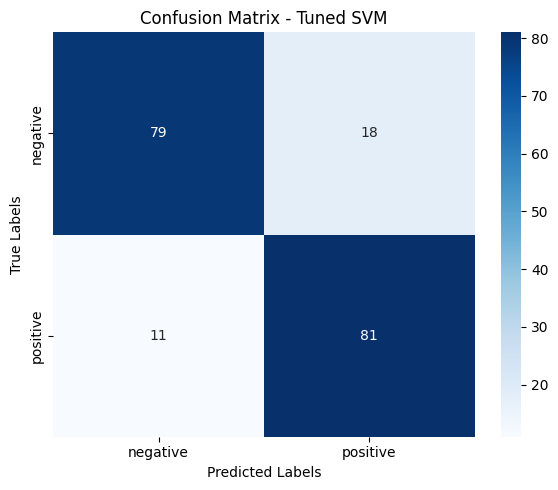

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump

# ==== Hyperparameter tuning dengan GridSearchCV ====
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # hanya untuk kernel non-linear
}

grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print(f"🎯 Best Parameters: {grid_search.best_params_}")
print(f"🎯 Best CV Score: {grid_search.best_score_:.4f}")

# Menggunakan model terbaik
svm_model = grid_search.best_estimator_

# Evaluasi pada data latih
svm_train_pred = svm_model.predict(X_train)
svm_train_acc = accuracy_score(y_train, svm_train_pred)

# Evaluasi pada data uji
svm_test_pred = svm_model.predict(X_test)
svm_test_acc = accuracy_score(y_test, svm_test_pred)

# Simpan model
dump(svm_model, 'model_svm_tuned_BERT.pkl')

# Output akurasi
print(f"✅ Akurasi Data Latih: {svm_train_acc:.4f}")
print(f"✅ Akurasi Data Uji: {svm_test_acc:.4f}")

# Classification report dan confusion matrix
print("Classification Report (Data Uji):")
report = classification_report(y_test, svm_test_pred, output_dict=True)

# Format angka dengan 4 angka di belakang koma
for label in report:
    if label != 'accuracy':  # Tidak perlu format untuk accuracy
        for metric in report[label]:
            report[label][metric] = f"{report[label][metric]:.4f}"

# Tampilkan classification report dengan format yang sudah diubah
print("Formatted Classification Report:")
print(pd.DataFrame(report).transpose())

cm_svm = confusion_matrix(y_test, svm_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix - Tuned SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


📦 Model Naive Bayes disimpan: models/model_nb.pkl
✅ Akurasi Naive Bayes: 0.7142857142857143
Formatted Classification Report:
             precision    recall  f1-score   support
negative        0.7172    0.7320    0.7245   97.0000
positive        0.7111    0.6957    0.7033   92.0000
accuracy      0.714286  0.714286  0.714286  0.714286
macro avg       0.7141    0.7138    0.7139  189.0000
weighted avg    0.7142    0.7143    0.7142  189.0000


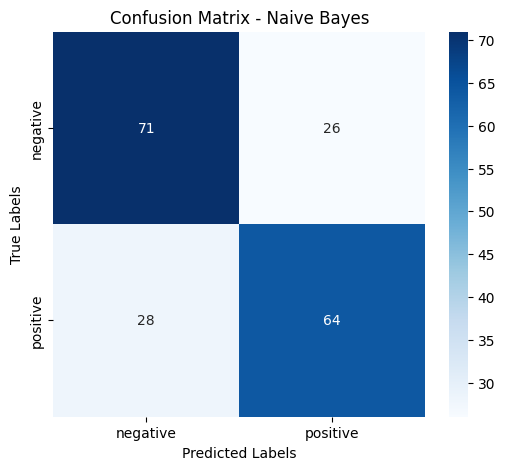

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# Inisialisasi model Naive Bayes
nb_model = GaussianNB()

# Latih model Naive Bayes
nb_model.fit(X_train, y_train)

# Prediksi dan evaluasi
nb_pred = nb_model.predict(X_test)
nb_acc = accuracy_score(y_test, nb_pred)

# Simpan model Naive Bayes ke file
dump(nb_model, 'model_nb_BERT.pkl')
print(f"📦 Model Naive Bayes disimpan: models/model_nb.pkl")

# Tampilkan akurasi, classification report, dan confusion matrix
print(f"✅ Akurasi Naive Bayes: {nb_acc}")

# Classification report dengan format 4 angka dibelakang koma
report = classification_report(y_test, nb_pred, output_dict=True)

# Format angka dengan 4 angka di belakang koma
for label in report:
    if label != 'accuracy':  # Tidak perlu format untuk accuracy
        for metric in report[label]:
            report[label][metric] = f"{report[label][metric]:.4f}"

# Tampilkan classification report dengan format yang sudah diubah
print("Formatted Classification Report:")
print(pd.DataFrame(report).transpose())

# Plot confusion matrix
cm_nb = confusion_matrix(y_test, nb_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
🎯 Best Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
🎯 Best CV Score: 0.8740
✅ Akurasi Data Latih: 0.9469
✅ Akurasi Data Uji: 0.8519
Formatted Classification Report:
             precision    recall  f1-score   support
negative        0.8791    0.8247    0.8511   97.0000
positive        0.8265    0.8804    0.8526   92.0000
accuracy      0.851852  0.851852  0.851852  0.851852
macro avg       0.8528    0.8526    0.8518  189.0000
weighted avg    0.8535    0.8519    0.8518  189.0000


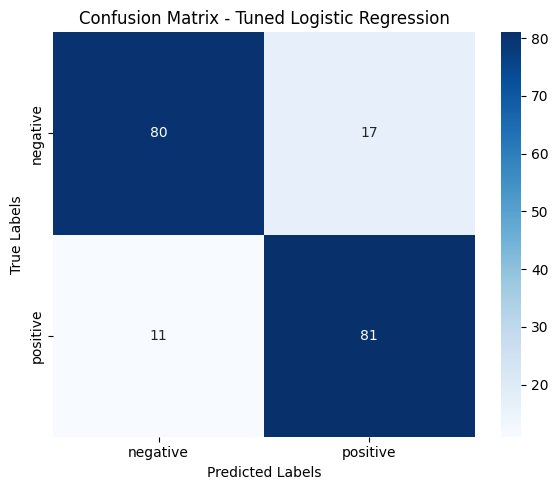

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump


# ==== Hyperparameter tuning dengan GridSearchCV ====
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print(f"🎯 Best Parameters: {grid_search.best_params_}")
print(f"🎯 Best CV Score: {grid_search.best_score_:.4f}")

# Menggunakan model terbaik
logreg_model = grid_search.best_estimator_

# Evaluasi pada data latih
logreg_train_pred = logreg_model.predict(X_train)
logreg_train_acc = accuracy_score(y_train, logreg_train_pred)

# Evaluasi pada data uji
logreg_test_pred = logreg_model.predict(X_test)
logreg_test_acc = accuracy_score(y_test, logreg_test_pred)

# Simpan model
dump(logreg_model, 'model_logreg_tuned_BERT.pkl')

# Output akurasi
print(f"✅ Akurasi Data Latih: {logreg_train_acc:.4f}")
print(f"✅ Akurasi Data Uji: {logreg_test_acc:.4f}")

# Classification report dengan format 4 angka dibelakang koma
report = classification_report(y_test, logreg_test_pred, output_dict=True)

# Format angka dengan 4 angka di belakang koma
for label in report:
    if label != 'accuracy':  # Tidak perlu format untuk accuracy
        for metric in report[label]:
            report[label][metric] = f"{report[label][metric]:.4f}"

# Tampilkan classification report dengan format yang sudah diubah
print("Formatted Classification Report:")
print(pd.DataFrame(report).transpose())

# Plot confusion matrix
cm_logreg = confusion_matrix(y_test, logreg_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters Logistic Regression: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

=== Voting Classifier_BERT ===
📦 Model Voting Classifier_BERT disimpan: model_voting_classifier_bert.pkl
✅ Akurasi Voting Classifier_BERT: 0.8412698412698413

Classification Report Voting Classifier_BERT:
              precision   recall f1-score   support
negative        0.8851   0.7938   0.8370   97.0000
positive        0.8039   0.8913   0.8454   92.0000
accuracy       0.84127  0.84127  0.84127   0.84127
macro avg       0.8445   0.8426   0.8412  189.0000
weighted avg    0.8456   0.8413   0.8410  189.0000


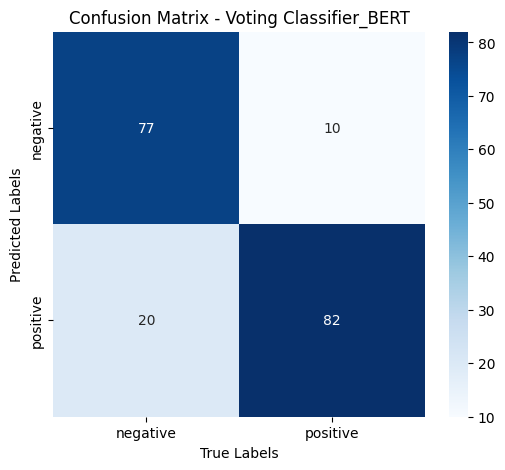


=== Stacking Classifier_BERT ===
📦 Model Stacking Classifier_BERT disimpan: model_stacking_classifier_bert.pkl
✅ Akurasi Stacking Classifier_BERT: 0.8518518518518519

Classification Report Stacking Classifier_BERT:
              precision    recall  f1-score   support
negative        0.8710    0.8351    0.8526   97.0000
positive        0.8333    0.8696    0.8511   92.0000
accuracy      0.851852  0.851852  0.851852  0.851852
macro avg       0.8522    0.8523    0.8518  189.0000
weighted avg    0.8526    0.8519    0.8519  189.0000


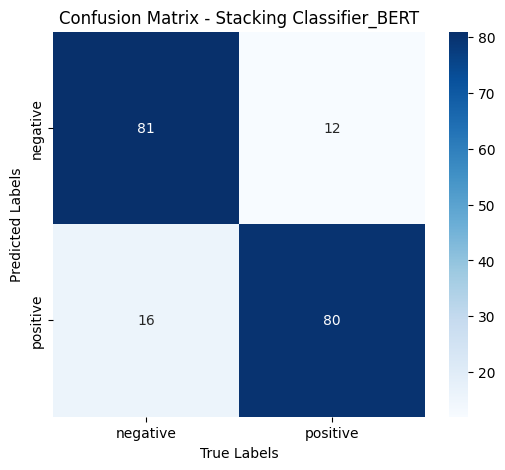


=== DES KNORA-E ===


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


📦 Model DES KNORA-E disimpan: model_des_knora-e.pkl
✅ Akurasi DES KNORA-E: 0.8518518518518519

Classification Report DES KNORA-E:
              precision    recall  f1-score   support
negative        0.8710    0.8351    0.8526   97.0000
positive        0.8333    0.8696    0.8511   92.0000
accuracy      0.851852  0.851852  0.851852  0.851852
macro avg       0.8522    0.8523    0.8518  189.0000
weighted avg    0.8526    0.8519    0.8519  189.0000


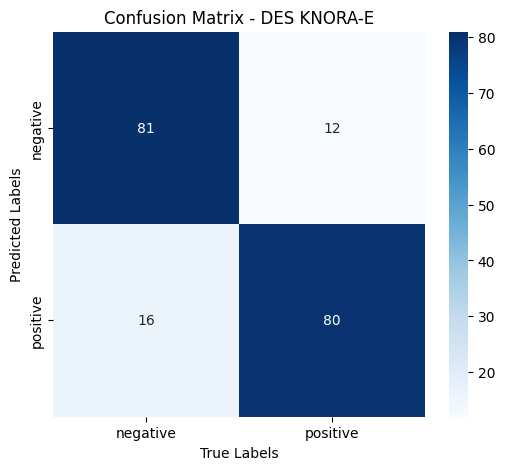

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump
from deslib.des.knora_e import KNORAE  # Import KNORA-E from DESlib

# === GridSearch untuk tuning SVM ===
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # hanya untuk kernel non-linear
}

grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print("Best Parameters SVM:", grid_search_svm.best_params_)

# Inisialisasi model SVM dengan best params dari GridSearch
best_svm_params = grid_search_svm.best_params_
svm_model = SVC(
    probability=True,
    C=best_svm_params['C'],
    kernel=best_svm_params['kernel'],
    gamma=best_svm_params['gamma'],
    random_state=42
)

# === GridSearch untuk tuning Logistic Regression ===
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search_lr = GridSearchCV(logreg, param_grid_lr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best Parameters Logistic Regression:", grid_search_lr.best_params_)

# Inisialisasi model Logistic Regression dengan best params dari GridSearch
best_lr_params = grid_search_lr.best_params_
lr_model = LogisticRegression(
    C=best_lr_params['C'],
    penalty=best_lr_params['penalty'],
    solver=best_lr_params['solver'],
    max_iter=best_lr_params['max_iter'],
    random_state=42
)

# Inisialisasi model Naive Bayes
nb_model = GaussianNB()

# === Fit the models individually before using them in KNORA-E ===
svm_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# === VotingClassifier ===
voting_clf = VotingClassifier(
    estimators=[('svm', svm_model), ('nb', nb_model), ('lr', lr_model)],
    voting='soft',
    weights=[2, 1, 2]
)

# === StackingClassifier ===
stacking_clf = StackingClassifier(
    estimators=[('svm', svm_model), ('nb', nb_model), ('lr', lr_model)],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5
)

# === Dynamic Ensemble Selection (DES) ===
# KNORA-E (K Nearest Optimal Classifier - Ensemble)
des_knorae = KNORAE(pool_classifiers=[svm_model, nb_model, lr_model], k=5)

# Daftar model untuk evaluasi
models = {
    'Voting Classifier_BERT': voting_clf,
    'Stacking Classifier_BERT': stacking_clf,
    'DES KNORA-E': des_knorae  # Menambahkan KNORA-E ke dalam daftar model
}

# Latih dan evaluasi setiap model
for name, model in models.items():
    print(f"\n=== {name} ===")

    # Latih model
    model.fit(X_train, y_train)

    # Prediksi dan evaluasi pada test set
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # Simpan model ke file
    model_filename = f"model_{name.lower().replace(' ', '_')}.pkl"
    dump(model, model_filename)
    print(f"📦 Model {name} disimpan: {model_filename}")

    # Tampilkan akurasi
    print(f"✅ Akurasi {name}: {acc}")

    # Classification report dengan format 4 angka dibelakang koma
    report = classification_report(y_test, y_pred, output_dict=True)

    # Format angka dengan 4 angka di belakang koma
    for label in report:
        if label != 'accuracy':  # Tidak perlu format untuk accuracy
            for metric in report[label]:
                report[label][metric] = f"{report[label][metric]:.4f}"

    # Tampilkan classification report dengan format yang sudah diubah
    print(f"\nClassification Report {name}:\n", pd.DataFrame(report).transpose())

    # Plot confusion matrix
    cm = confusion_matrix(y_pred, y_test)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['negative', 'positive'],
                yticklabels=['negative', 'positive'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters Logistic Regression: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

=== Voting Classifier_BERT ===
📦 Model Voting Classifier_BERT disimpan: model_voting_classifier_bert.pkl
✅ Akurasi Voting Classifier_BERT: 0.8412698412698413

Classification Report Voting Classifier_BERT:
              precision   recall f1-score   support
negative        0.8602   0.8247   0.8421   97.0000
positive        0.8229   0.8587   0.8404   92.0000
accuracy       0.84127  0.84127  0.84127   0.84127
macro avg       0.8416   0.8417   0.8413  189.0000
weighted avg    0.8421   0.8413   0.8413  189.0000


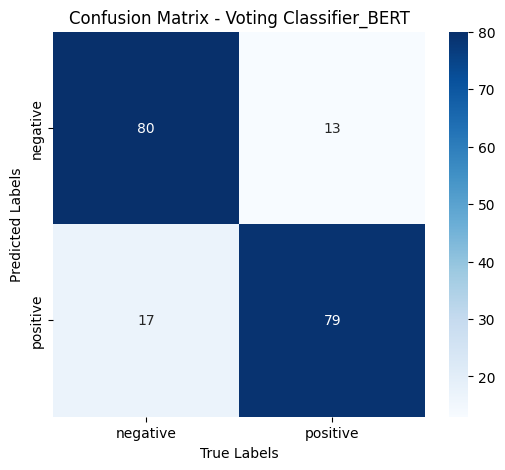


=== Stacking Classifier_BERT ===
📦 Model Stacking Classifier_BERT disimpan: model_stacking_classifier_bert.pkl
✅ Akurasi Stacking Classifier_BERT: 0.8518518518518519

Classification Report Stacking Classifier_BERT:
              precision    recall  f1-score   support
negative        0.8710    0.8351    0.8526   97.0000
positive        0.8333    0.8696    0.8511   92.0000
accuracy      0.851852  0.851852  0.851852  0.851852
macro avg       0.8522    0.8523    0.8518  189.0000
weighted avg    0.8526    0.8519    0.8519  189.0000


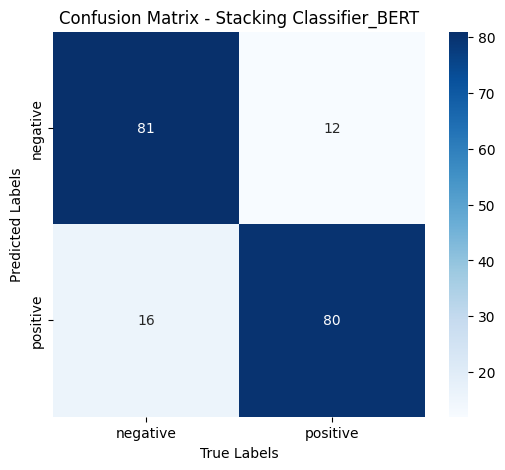


=== DES KNORA-E ===


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


📦 Model DES KNORA-E disimpan: model_des_knora-e.pkl
✅ Akurasi DES KNORA-E: 0.8518518518518519

Classification Report DES KNORA-E:
              precision    recall  f1-score   support
negative        0.8710    0.8351    0.8526   97.0000
positive        0.8333    0.8696    0.8511   92.0000
accuracy      0.851852  0.851852  0.851852  0.851852
macro avg       0.8522    0.8523    0.8518  189.0000
weighted avg    0.8526    0.8519    0.8519  189.0000


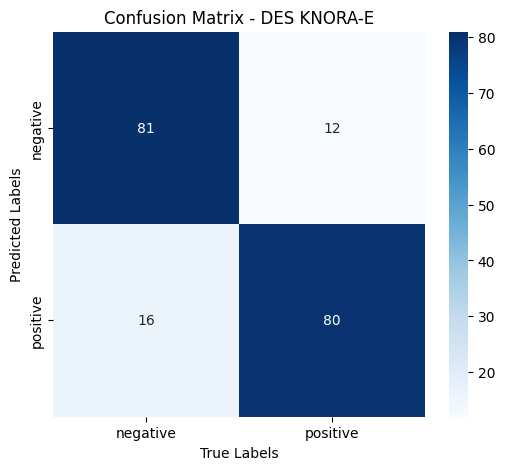

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump
from deslib.des.knora_e import KNORAE  # Import KNORA-E from DESlib

# === GridSearch untuk tuning SVM ===
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # hanya untuk kernel non-linear
}

grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print("Best Parameters SVM:", grid_search_svm.best_params_)

# Inisialisasi model SVM dengan best params dari GridSearch
best_svm_params = grid_search_svm.best_params_
svm_model = SVC(
    probability=True,
    C=best_svm_params['C'],
    kernel=best_svm_params['kernel'],
    gamma=best_svm_params['gamma'],
    random_state=42
)

# === GridSearch untuk tuning Logistic Regression ===
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search_lr = GridSearchCV(logreg, param_grid_lr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best Parameters Logistic Regression:", grid_search_lr.best_params_)

# Inisialisasi model Logistic Regression dengan best params dari GridSearch
best_lr_params = grid_search_lr.best_params_
lr_model = LogisticRegression(
    C=best_lr_params['C'],
    penalty=best_lr_params['penalty'],
    solver=best_lr_params['solver'],
    max_iter=best_lr_params['max_iter'],
    random_state=42
)

# Inisialisasi model Naive Bayes
nb_model = GaussianNB()

# === Fit the models individually before using them in KNORA-E ===
svm_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# === VotingClassifier ===
voting_clf = VotingClassifier(
    estimators=[('svm', svm_model), ('nb', nb_model), ('lr', lr_model)],
    voting='soft',

)

# === StackingClassifier ===
stacking_clf = StackingClassifier(
    estimators=[('svm', svm_model), ('nb', nb_model), ('lr', lr_model)],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5
)

# === Dynamic Ensemble Selection (DES) ===
# KNORA-E (K Nearest Optimal Classifier - Ensemble)
des_knorae = KNORAE(pool_classifiers=[svm_model, nb_model, lr_model], k=5)

# Daftar model untuk evaluasi
models = {
    'Voting Classifier_BERT': voting_clf,
    'Stacking Classifier_BERT': stacking_clf,
    'DES KNORA-E': des_knorae  # Menambahkan KNORA-E ke dalam daftar model
}

# Latih dan evaluasi setiap model
for name, model in models.items():
    print(f"\n=== {name} ===")

    # Latih model
    model.fit(X_train, y_train)

    # Prediksi dan evaluasi pada test set
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # Simpan model ke file
    model_filename = f"model_{name.lower().replace(' ', '_')}.pkl"
    dump(model, model_filename)
    print(f"📦 Model {name} disimpan: {model_filename}")

    # Tampilkan akurasi
    print(f"✅ Akurasi {name}: {acc}")

    # Classification report dengan format 4 angka dibelakang koma
    report = classification_report(y_test, y_pred, output_dict=True)

    # Format angka dengan 4 angka di belakang koma
    for label in report:
        if label != 'accuracy':  # Tidak perlu format untuk accuracy
            for metric in report[label]:
                report[label][metric] = f"{report[label][metric]:.4f}"

    # Tampilkan classification report dengan format yang sudah diubah
    print(f"\nClassification Report {name}:\n", pd.DataFrame(report).transpose())

    # Plot confusion matrix
    cm = confusion_matrix(y_pred, y_test)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['negative', 'positive'],
                yticklabels=['negative', 'positive'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
🎯 Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
🎯 Best CV Score: 0.8819
✅ Akurasi Data Latih: 0.9973
✅ Akurasi Data Uji: 0.8466
Classification Report (Data Uji):
              precision    recall  f1-score   support

    negative       0.88      0.81      0.84        97
    positive       0.82      0.88      0.85        92

    accuracy                           0.85       189
   macro avg       0.85      0.85      0.85       189
weighted avg       0.85      0.85      0.85       189



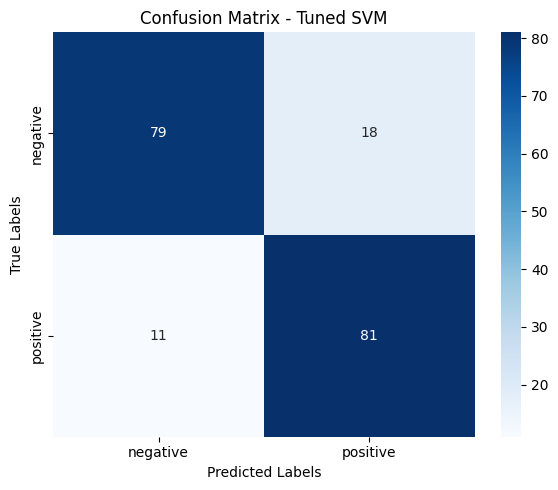

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump



# ==== Hyperparameter tuning dengan GridSearchCV ====
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # hanya untuk kernel non-linear
}

grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print(f"🎯 Best Parameters: {grid_search.best_params_}")
print(f"🎯 Best CV Score: {grid_search.best_score_:.4f}")

# Menggunakan model terbaik
svm_model = grid_search.best_estimator_

# Evaluasi pada data latih
svm_train_pred = svm_model.predict(X_train)
svm_train_acc = accuracy_score(y_train, svm_train_pred)


# Evaluasi pada data uji
svm_test_pred = svm_model.predict(X_test)
svm_test_acc = accuracy_score(y_test, svm_test_pred)

# Simpan model
dump(svm_model, 'model_svm_tuned_BERT.pkl')

# Output akurasi
print(f"✅ Akurasi Data Latih: {svm_train_acc:.4f}")
print(f"✅ Akurasi Data Uji: {svm_test_acc:.4f}")

# Classification report dan confusion matrix
print("Classification Report (Data Uji):")
print(classification_report(y_test, svm_test_pred))

cm_svm = confusion_matrix(y_test, svm_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative',  'positive'],
            yticklabels=['negative',  'positive'])
plt.title("Confusion Matrix - Tuned SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


📦 Model Naive Bayes disimpan: models/model_nb.pkl
✅ Akurasi Naive Bayes: 0.7142857142857143
              precision    recall  f1-score   support

    negative       0.72      0.73      0.72        97
    positive       0.71      0.70      0.70        92

    accuracy                           0.71       189
   macro avg       0.71      0.71      0.71       189
weighted avg       0.71      0.71      0.71       189



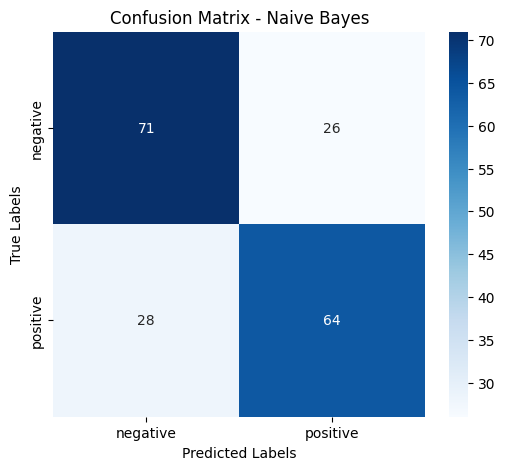

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# Inisialisasi model Naive Bayes
nb_model = GaussianNB()

# Latih model Naive Bayes
nb_model.fit(X_train, y_train)

# Prediksi dan evaluasi
nb_pred = nb_model.predict(X_test)
nb_acc = accuracy_score(y_test, nb_pred)

# Simpan model Naive Bayes ke file
dump(nb_model, 'model_nb_BERT.pkl')
print(f"📦 Model Naive Bayes disimpan: models/model_nb.pkl")

# Tampilkan akurasi, classification report, dan confusion matrix
print(f"✅ Akurasi Naive Bayes: {nb_acc}")
print(classification_report(y_test, nb_pred))

# Plot confusion matrix
cm_nb = confusion_matrix(y_test, nb_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
🎯 Best Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
🎯 Best CV Score: 0.8740
✅ Akurasi Data Latih: 0.9469
✅ Akurasi Data Uji: 0.8519
Classification Report (Data Uji):
              precision    recall  f1-score   support

    negative       0.88      0.82      0.85        97
    positive       0.83      0.88      0.85        92

    accuracy                           0.85       189
   macro avg       0.85      0.85      0.85       189
weighted avg       0.85      0.85      0.85       189



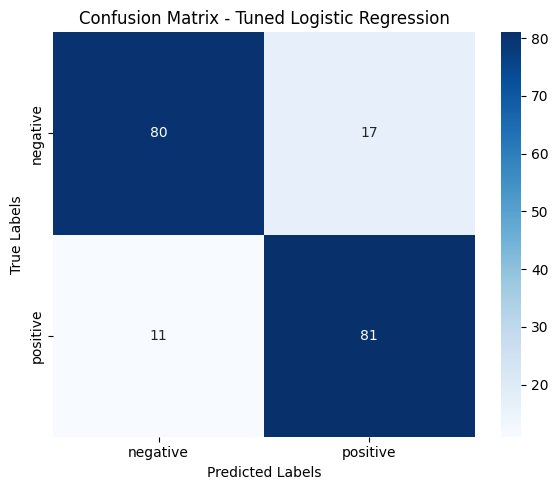

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump


# ==== Hyperparameter tuning dengan GridSearchCV ====
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print(f"🎯 Best Parameters: {grid_search.best_params_}")
print(f"🎯 Best CV Score: {grid_search.best_score_:.4f}")

# Menggunakan model terbaik
logreg_model = grid_search.best_estimator_

# Evaluasi pada data latih
logreg_train_pred = logreg_model.predict(X_train)
logreg_train_acc = accuracy_score(y_train, logreg_train_pred)


# Evaluasi pada data uji
logreg_test_pred = logreg_model.predict(X_test)
logreg_test_acc = accuracy_score(y_test, logreg_test_pred)

# Simpan model
dump(logreg_model, 'model_logreg_tuned_BERT.pkl')

# Output akurasi
print(f"✅ Akurasi Data Latih: {logreg_train_acc:.4f}")
print(f"✅ Akurasi Data Uji: {logreg_test_acc:.4f}")

# Classification report dan confusion matrix
print("Classification Report (Data Uji):")
print(classification_report(y_test, logreg_test_pred))

cm_logreg = confusion_matrix(y_test, logreg_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters Logistic Regression: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

=== Voting Classifier_BERT ===
📦 Model Voting Classifier_BERT disimpan: model_voting_classifier_bert.pkl
✅ Akurasi Voting Classifier_BERT: 0.8412698412698413

Classification Report Voting Classifier_BERT:
               precision    recall  f1-score   support

    negative       0.89      0.79      0.84        97
    positive       0.80      0.89      0.85        92

    accuracy                           0.84       189
   macro avg       0.84      0.84      0.84       189
weighted avg       0.85      0.84      0.84       189



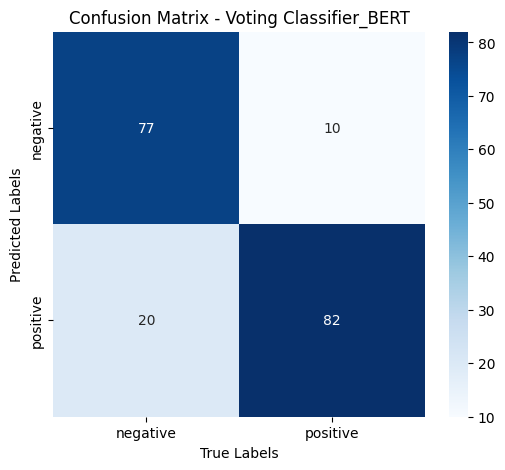


=== Stacking Classifier_BERT ===
📦 Model Stacking Classifier_BERT disimpan: model_stacking_classifier_bert.pkl
✅ Akurasi Stacking Classifier_BERT: 0.8518518518518519

Classification Report Stacking Classifier_BERT:
               precision    recall  f1-score   support

    negative       0.87      0.84      0.85        97
    positive       0.83      0.87      0.85        92

    accuracy                           0.85       189
   macro avg       0.85      0.85      0.85       189
weighted avg       0.85      0.85      0.85       189



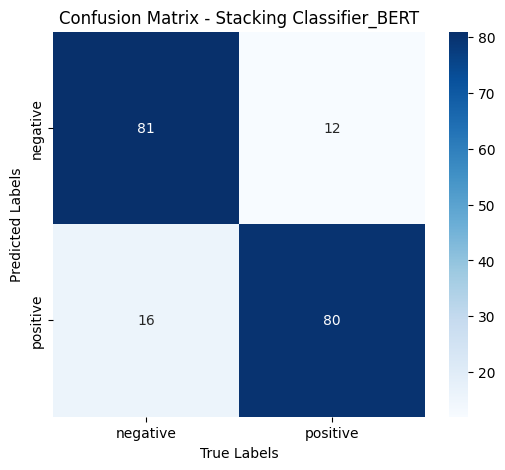


=== DES KNORA-E ===


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


📦 Model DES KNORA-E disimpan: model_des_knora-e.pkl
✅ Akurasi DES KNORA-E: 0.8518518518518519

Classification Report DES KNORA-E:
               precision    recall  f1-score   support

    negative       0.87      0.84      0.85        97
    positive       0.83      0.87      0.85        92

    accuracy                           0.85       189
   macro avg       0.85      0.85      0.85       189
weighted avg       0.85      0.85      0.85       189



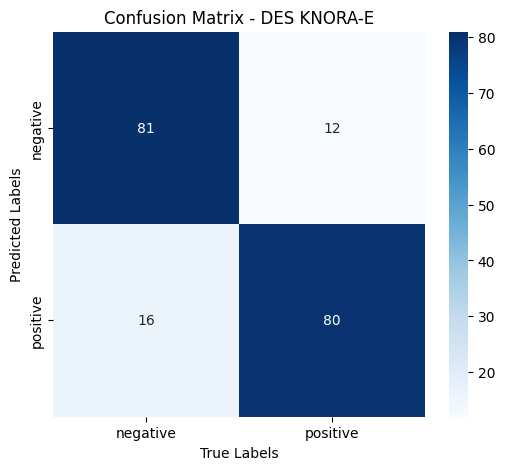

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump
from deslib.des.knora_e import KNORAE  # Import KNORA-E from DESlib

# === GridSearch untuk tuning SVM ===
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # hanya untuk kernel non-linear
}

grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print("Best Parameters SVM:", grid_search_svm.best_params_)

# Inisialisasi model SVM dengan best params dari GridSearch
best_svm_params = grid_search_svm.best_params_
svm_model = SVC(
    probability=True,
    C=best_svm_params['C'],
    kernel=best_svm_params['kernel'],
    gamma=best_svm_params['gamma'],
    random_state=42
)

# === GridSearch untuk tuning Logistic Regression ===
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search_lr = GridSearchCV(logreg, param_grid_lr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best Parameters Logistic Regression:", grid_search_lr.best_params_)

# Inisialisasi model Logistic Regression dengan best params dari GridSearch
best_lr_params = grid_search_lr.best_params_
lr_model = LogisticRegression(
    C=best_lr_params['C'],
    penalty=best_lr_params['penalty'],
    solver=best_lr_params['solver'],
    max_iter=best_lr_params['max_iter'],
    random_state=42
)

# Inisialisasi model Naive Bayes
nb_model = GaussianNB()

# === Fit the models individually before using them in KNORA-E ===
svm_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# === VotingClassifier ===
voting_clf = VotingClassifier(
    estimators=[('svm', svm_model), ('nb', nb_model), ('lr', lr_model)],
    voting='soft',
    weights=[2, 1, 2]
)

# === StackingClassifier ===
stacking_clf = StackingClassifier(
    estimators=[('svm', svm_model), ('nb', nb_model), ('lr', lr_model)],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5
)

# === Dynamic Ensemble Selection (DES) ===
# KNORA-E (K Nearest Optimal Classifier - Ensemble)
des_knorae = KNORAE(pool_classifiers=[svm_model, nb_model, lr_model], k=5)

# Daftar model untuk evaluasi
models = {
    'Voting Classifier_BERT': voting_clf,
    'Stacking Classifier_BERT': stacking_clf,
    'DES KNORA-E': des_knorae  # Menambahkan KNORA-E ke dalam daftar model
}

# Latih dan evaluasi setiap model
for name, model in models.items():
    print(f"\n=== {name} ===")

    # Latih model
    model.fit(X_train, y_train)

    # Prediksi dan evaluasi pada test set
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # Simpan model ke file
    model_filename = f"model_{name.lower().replace(' ', '_')}.pkl"
    dump(model, model_filename)
    print(f"📦 Model {name} disimpan: {model_filename}")

    # Tampilkan akurasi dan classification report
    print(f"✅ Akurasi {name}: {acc}")
    print(f"\nClassification Report {name}:\n", classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_pred, y_test)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['negative', 'positive'],
                yticklabels=['negative', 'positive'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
📦 Model Voting Classifier disimpan: models/model_voting.pkl
✅ Akurasi Voting Classifier: 0.8253968253968254
              precision    recall  f1-score   support

    negative       0.82      0.81      0.82        91
    positive       0.83      0.84      0.83        98

    accuracy                           0.83       189
   macro avg       0.83      0.82      0.83       189
weighted avg       0.83      0.83      0.83       189



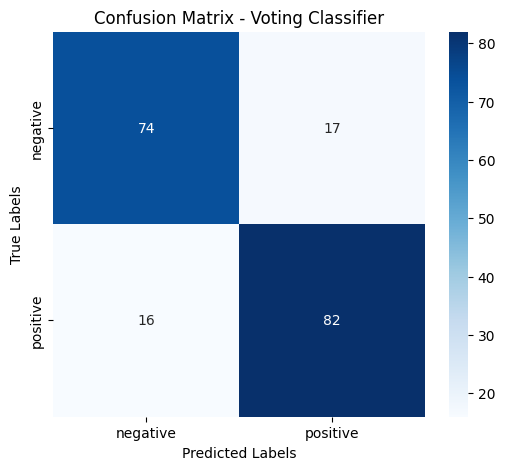

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# Inisialisasi model SVM dan Naive Bayes
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print("Best Parameters SVM:", grid_search_svm.best_params_)

best_svm_params = grid_search_svm.best_params_
svm_model = SVC(
    probability=True,
    C=best_svm_params['C'],
    kernel=best_svm_params['kernel'],
    gamma=best_svm_params['gamma']
)
nb_model = GaussianNB()

# Voting classifier
voting_clf = VotingClassifier(estimators=[('svm', svm_model), ('nb', nb_model)], voting='soft',  weights=[2,1] )

# Latih model Voting Classifier
voting_clf.fit(X_train, y_train)

# Prediksi dan evaluasi
voting_pred = voting_clf.predict(X_test)
voting_acc = accuracy_score(y_test, voting_pred)

# Simpan model Voting Classifier ke file
dump(voting_clf, 'model_voting.pkl')
print(f"📦 Model Voting Classifier disimpan: models/model_voting.pkl")

# Tampilkan akurasi, classification report, dan confusion matrix
print(f"✅ Akurasi Voting Classifier: {voting_acc}")
print(classification_report(y_test, voting_pred))

# Plot confusion matrix
cm_voting = confusion_matrix(y_test, voting_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_voting, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix - Voting Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
df

,ulasan,truth_label,confidence
0,tidak bisa verifikasi akun lewat wa selalu ero...,negative,"7,97E+15"
1,sigap dan tanggap mengatasi keluhan,positive,"6,69E+15"
2,ini gimana caranya kalau lupa sandi email mau...,neutral,"9,67E+15"
3,moga bisa menjembatani warga dengan pengurus a...,neutral,"9,93E+13"
4,min mau daftar koq nik sdh terdaftar bagaimana...,neutral,"9,88E+15"
...,...,...,...
998,sapu jagat sngat baik sekali,positive,"9,98E+15"
999,mantap wis semoga fitur nya ditambah terutama ...,positive,"9,26E+15"
1000,mantap,positive,"9,99E+15"
1001,sangat bagus dan bermanfaat untuk mempermudah ...,positive,"9,97E+15"


In [ ]:
df.columns

Index(['ulasan', 'truth_label', 'confidence'], dtype='object')

In [ ]:
df = df[df['truth_label'] != 'neutral']

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters Logistic Regression: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
📦 Model Voting Classifier disimpan: model_voting.pkl
✅ Akurasi Voting Classifier: 0.8465608465608465
              precision    recall  f1-score   support

    negative       0.83      0.86      0.84        91
    positive       0.86      0.84      0.85        98

    accuracy                           0.85       189
   macro avg       0.85      0.85      0.85       189
weighted avg       0.85      0.85      0.85       189



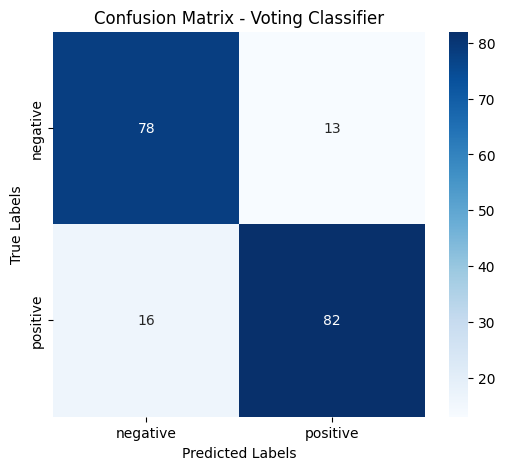

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# === GridSearch untuk tuning SVM ===
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # hanya untuk kernel non-linear
}

grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print("Best Parameters SVM:", grid_search_svm.best_params_)

# Inisialisasi model SVM dengan best params dari GridSearch
best_svm_params = grid_search_svm.best_params_
svm_model = SVC(
    probability=True,
    C=best_svm_params['C'],
    kernel=best_svm_params['kernel'],
    gamma=best_svm_params['gamma']
)

# === GridSearch untuk tuning Logistic Regression ===
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search_lr = GridSearchCV(logreg, param_grid_lr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best Parameters Logistic Regression:", grid_search_lr.best_params_)

# Inisialisasi model Logistic Regression dengan best params dari GridSearch
best_lr_params = grid_search_lr.best_params_
lr_model = LogisticRegression(
    C=best_lr_params['C'],
    penalty=best_lr_params['penalty'],
    solver=best_lr_params['solver'],
    max_iter=best_lr_params['max_iter']
)

# Inisialisasi model Naive Bayes
nb_model = GaussianNB()

# Voting classifier dengan 3 model dan bobot
voting_clf = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('nb', nb_model),
        ('lr', lr_model)
    ],
    voting='soft',
    weights=[2, 1, 2]
)

# Latih Voting Classifier
voting_clf.fit(X_train, y_train)

# Prediksi dan evaluasi
voting_pred = voting_clf.predict(X_test)
voting_acc = accuracy_score(y_test, voting_pred)

# Simpan model Voting Classifier ke file
dump(voting_clf, 'model_voting.pkl')
print(f"📦 Model Voting Classifier disimpan: model_voting.pkl")

# Tampilkan akurasi, classification report, dan confusion matrix
print(f"✅ Akurasi Voting Classifier: {voting_acc}")
print(classification_report(y_test, voting_pred))

# Plot confusion matrix
cm_voting = confusion_matrix(y_test, voting_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_voting, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative',  'positive'],
            yticklabels=['negative',  'positive'])
plt.title("Confusion Matrix - Voting Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters Logistic Regression: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
📦 Model Voting Classifier disimpan: model_voting.pkl
✅ Akurasi Voting Classifier: 0.8571428571428571
              precision    recall  f1-score   support

    negative       0.84      0.87      0.85        91
    positive       0.87      0.85      0.86        98

    accuracy                           0.86       189
   macro avg       0.86      0.86      0.86       189
weighted avg       0.86      0.86      0.86       189



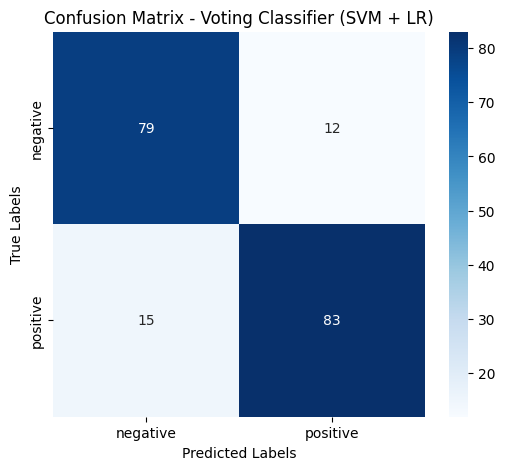

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# === GridSearch untuk tuning SVM ===
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print("Best Parameters SVM:", grid_search_svm.best_params_)

best_svm_params = grid_search_svm.best_params_
svm_model = SVC(
    probability=True,
    C=best_svm_params['C'],
    kernel=best_svm_params['kernel'],
    gamma=best_svm_params['gamma']
)

# === GridSearch untuk Logistic Regression ===
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [100, 200]
}

logreg = LogisticRegression()
grid_search_lr = GridSearchCV(logreg, param_grid_lr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best Parameters Logistic Regression:", grid_search_lr.best_params_)

best_lr_params = grid_search_lr.best_params_
lr_model = LogisticRegression(
    C=best_lr_params['C'],
    penalty=best_lr_params['penalty'],
    solver=best_lr_params['solver'],
    max_iter=best_lr_params['max_iter']
)

# Voting classifier hanya dengan SVM dan Logistic Regression
voting_clf = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('lr', lr_model)
    ],
    voting='soft',

)

# Latih Voting Classifier
voting_clf.fit(X_train, y_train)

# Prediksi dan evaluasi
voting_pred = voting_clf.predict(X_test)
voting_acc = accuracy_score(y_test, voting_pred)

# Simpan model Voting Classifier
dump(voting_clf, 'model_voting.pkl')
print(f"📦 Model Voting Classifier disimpan: model_voting.pkl")

# Tampilkan hasil evaluasi
print(f"✅ Akurasi Voting Classifier: {voting_acc}")
print(classification_report(y_test, voting_pred))

# Plot confusion matrix
cm_voting = confusion_matrix(y_test, voting_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_voting, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative',  'positive'],
            yticklabels=['negative',  'positive'])
plt.title("Confusion Matrix - Voting Classifier (SVM + LR)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters Logistic Regression: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
📦 Model Voting Classifier disimpan: model_voting.pkl
✅ Akurasi Voting Classifier: 0.8306878306878307
              precision    recall  f1-score   support

    negative       0.81      0.85      0.83        91
    positive       0.85      0.82      0.83        98

    accuracy                           0.83       189
   macro avg       0.83      0.83      0.83       189
weighted avg       0.83      0.83      0.83       189



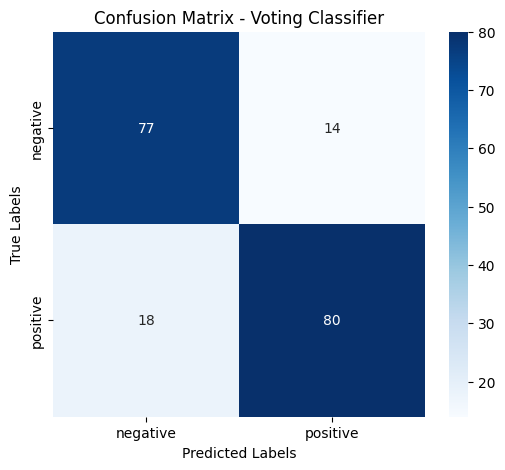

In [ ]:
from sklearn.ensemble import VotingClassifier
#from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump


# === GridSearch untuk tuning Logistic Regression ===
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search_lr = GridSearchCV(logreg, param_grid_lr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best Parameters Logistic Regression:", grid_search_lr.best_params_)

# Inisialisasi model Logistic Regression dengan best params dari GridSearch
best_lr_params = grid_search_lr.best_params_
lr_model = LogisticRegression(
    C=best_lr_params['C'],
    penalty=best_lr_params['penalty'],
    solver=best_lr_params['solver'],
    max_iter=best_lr_params['max_iter']
)

# Inisialisasi model Naive Bayes
nb_model = GaussianNB()

# Voting classifier dengan 3 model dan bobot
voting_clf = VotingClassifier(
    estimators=[

        ('nb', nb_model),
        ('lr', lr_model)
    ],
    voting='soft',
  weights=[1, 2]
)

# Latih Voting Classifier
voting_clf.fit(X_train, y_train)

# Prediksi dan evaluasi
voting_pred = voting_clf.predict(X_test)
voting_acc = accuracy_score(y_test, voting_pred)

# Simpan model Voting Classifier ke file
dump(voting_clf, 'model_voting.pkl')
print(f"📦 Model Voting Classifier disimpan: model_voting.pkl")

# Tampilkan akurasi, classification report, dan confusion matrix
print(f"✅ Akurasi Voting Classifier: {voting_acc}")
print(classification_report(y_test, voting_pred))

# Plot confusion matrix
cm_voting = confusion_matrix(y_test, voting_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_voting, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative',  'positive'],
            yticklabels=['negative',  'positive'])
plt.title("Confusion Matrix - Voting Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



# untuk split 70 : 20 : 10 hasil voting classifier dengan regression (3 model) = 0.85 dan tanpa regression (2 model) = 0.76 kemudian untuk 2 model (svm dan lr) = 0.86

# - Model SVM + LR adalah kombinasi terbaik untuk ensemble Voting Classifier pada dataset ini, menghasilkan akurasi dan metrik evaluasi terbaik dengan performa seimbang di kedua kelas.

# - Penambahan NB dalam ensemble (baik dengan SVM saja maupun SVM+LR) menurunkan performa secara signifikan, yang kemungkinan karena NB kurang cocok untuk data ini atau menghasilkan prediksi yang kurang akurat dan membuat voting menjadi kurang optimal.




# TF IDF

- Load dan hapus neutral

In [ ]:
import pandas as pd

file_path = 'df_manual.csv'  # Ganti dengan path file Anda
df = pd.read_csv(file_path, sep=';', on_bad_lines='skip')

In [ ]:
df = df[df['truth_label'] != 'neutral']

In [ ]:
df.columns

Index(['ulasan', 'truth_label', 'confidence'], dtype='object')

In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 737.0 kB/s eta 0:00:00


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

factory = StopWordRemoverFactory()
indonesian_stopwords = factory.get_stop_words()

le = LabelEncoder()
y = le.fit_transform(df['truth_label'])
#splitting data
texts = df['ulasan'].tolist()
X_text_train, X_text_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42
)

#ekstraksi menggunakan hasil split
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words=indonesian_stopwords
)
X_train = tfidf_vectorizer.fit_transform(X_text_train)

X_test = tfidf_vectorizer.transform(X_text_test)


print(f"Training data: {X_train.shape[0]}")    # ~80%
print(f"Testing data: {X_test.shape[0]}")      # ~20%

Training data: 754
Testing data: 189


Fitting 5 folds for each of 12 candidates, totalling 60 fits
🎯 Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
🎯 Best CV Score: 0.9032
✅ Akurasi Data Latih: 0.9748
✅ Akurasi Data Uji: 0.8571

Classification Report (Data Uji):
             precision    recall  f1-score   support
0               0.8431    0.8866    0.8643   97.0000
1               0.8736    0.8261    0.8492   92.0000
accuracy      0.857143  0.857143  0.857143  0.857143
macro avg       0.8584    0.8563    0.8567  189.0000
weighted avg    0.8579    0.8571    0.8569  189.0000


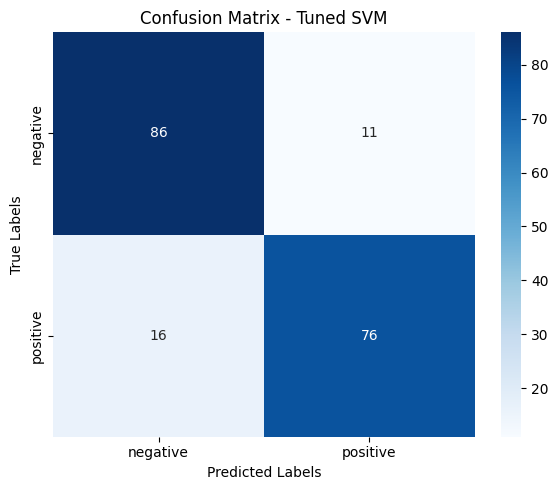

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump

# ==== Hyperparameter tuning dengan GridSearchCV ====
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # hanya untuk kernel non-linear
}

grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print(f"🎯 Best Parameters: {grid_search.best_params_}")
print(f"🎯 Best CV Score: {grid_search.best_score_:.4f}")

# Menggunakan model terbaik
svm_model = grid_search.best_estimator_

# Evaluasi pada data latih
svm_train_pred = svm_model.predict(X_train)
svm_train_acc = accuracy_score(y_train, svm_train_pred)

# Evaluasi pada data uji
svm_test_pred = svm_model.predict(X_test)
svm_test_acc = accuracy_score(y_test, svm_test_pred)

# Simpan model
dump(svm_model, 'model_svm_tuned.pkl')

# Output akurasi
print(f"✅ Akurasi Data Latih: {svm_train_acc:.4f}")
print(f"✅ Akurasi Data Uji: {svm_test_acc:.4f}")

# Classification report dengan format 4 angka dibelakang koma
report = classification_report(y_test, svm_test_pred, output_dict=True)

# Format angka dengan 4 angka di belakang koma
for label in report:
    if label != 'accuracy':  # Tidak perlu format untuk accuracy
        for metric in report[label]:
            report[label][metric] = f"{report[label][metric]:.4f}"

# Tampilkan classification report dengan format yang sudah diubah
print(f"\nClassification Report (Data Uji):")
print(pd.DataFrame(report).transpose())

# Confusion matrix
cm_svm = confusion_matrix(y_test, svm_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix - Tuned SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


📦 Model Naive Bayes Multinomial disimpan: model_nb_multinomial.pkl
✅ Akurasi Naive Bayes: 0.8624338624338624

Classification Report (Data Uji):
             precision    recall  f1-score   support
0               0.8660    0.8660    0.8660   97.0000
1               0.8587    0.8587    0.8587   92.0000
accuracy      0.862434  0.862434  0.862434  0.862434
macro avg       0.8623    0.8623    0.8623  189.0000
weighted avg    0.8624    0.8624    0.8624  189.0000


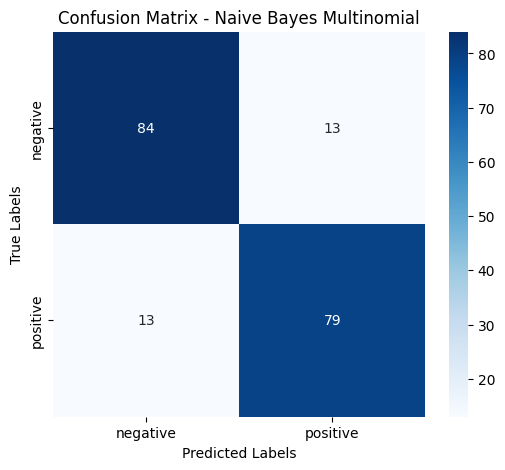

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# Inisialisasi model Naive Bayes Multinomial
nb_model = MultinomialNB()

# Latih model Naive Bayes
# Tidak perlu mengkonversi sparse matrix ke array, karena MultinomialNB dapat menangani sparse matrix
nb_model.fit(X_train, y_train)

# Prediksi dan evaluasi
nb_pred = nb_model.predict(X_test)
nb_acc = accuracy_score(y_test, nb_pred)

# Simpan model Naive Bayes ke file
# It's generally better practice to save models in a designated folder
# You might need to create the 'models' directory if it doesn't exist
# import os
# os.makedirs('models', exist_ok=True)
dump(nb_model, 'model_nb_Multinomial_tfidf.pkl')
print(f"📦 Model Naive Bayes Multinomial disimpan: model_nb_multinomial.pkl") # Updated path

# Tampilkan akurasi
print(f"✅ Akurasi Naive Bayes: {nb_acc}")

# Classification report dengan format 4 angka dibelakang koma
report = classification_report(y_test, nb_pred, output_dict=True)

# Format angka dengan 4 angka di belakang koma
for label in report:
    if label != 'accuracy':  # Tidak perlu format untuk accuracy
        for metric in report[label]:
            report[label][metric] = f"{report[label][metric]:.4f}"

# Tampilkan classification report dengan format yang sudah diubah
print("\nClassification Report (Data Uji):")
print(pd.DataFrame(report).transpose())

# Plot confusion matrix
cm_nb = confusion_matrix(y_test, nb_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix - Naive Bayes Multinomial")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
🎯 Best Parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
🎯 Best CV Score: 0.9364
✅ Akurasi Data Latih: 0.9960
✅ Akurasi Data Uji: 0.8995

Classification Report (Data Uji):
             precision    recall  f1-score   support
0               0.9432    0.8557    0.8973   97.0000
1               0.8614    0.9457    0.9016   92.0000
accuracy      0.899471  0.899471  0.899471  0.899471
macro avg       0.9023    0.9007    0.8994  189.0000
weighted avg    0.9034    0.8995    0.8994  189.0000


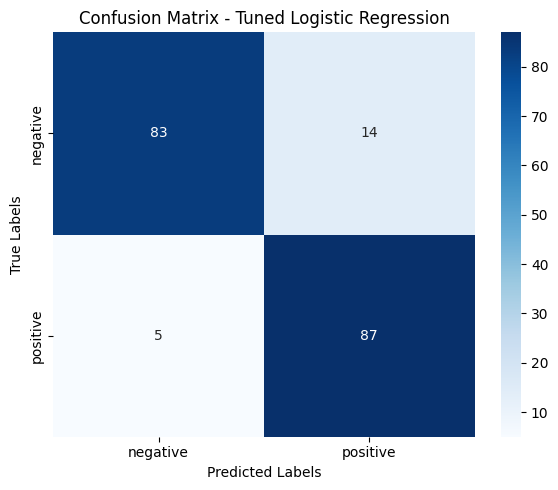

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump

# ==== Hyperparameter tuning dengan GridSearchCV ====
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print(f"🎯 Best Parameters: {grid_search.best_params_}")
print(f"🎯 Best CV Score: {grid_search.best_score_:.4f}")

# Menggunakan model terbaik
logreg_model = grid_search.best_estimator_

# Evaluasi pada data latih
logreg_train_pred = logreg_model.predict(X_train)
logreg_train_acc = accuracy_score(y_train, logreg_train_pred)

# Evaluasi pada data uji
logreg_test_pred = logreg_model.predict(X_test)
logreg_test_acc = accuracy_score(y_test, logreg_test_pred)

# Simpan model
dump(logreg_model, 'model_logreg_tuned.pkl')

# Output akurasi
print(f"✅ Akurasi Data Latih: {logreg_train_acc:.4f}")
print(f"✅ Akurasi Data Uji: {logreg_test_acc:.4f}")

# Classification report dengan format 4 angka dibelakang koma
report = classification_report(y_test, logreg_test_pred, output_dict=True)

# Format angka dengan 4 angka di belakang koma
for label in report:
    if label != 'accuracy':  # Tidak perlu format untuk accuracy
        for metric in report[label]:
            report[label][metric] = f"{report[label][metric]:.4f}"

# Tampilkan classification report dengan format yang sudah diubah
print("\nClassification Report (Data Uji):")
print(pd.DataFrame(report).transpose())

# Confusion matrix
cm_logreg = confusion_matrix(y_test, logreg_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters Logistic Regression: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

=== Voting Classifier ===
📦 Model Voting Classifier disimpan: model_voting_classifier.pkl
✅ Akurasi Voting Classifier: 0.9047619047619048

Classification Report Voting Classifier:
              precision    recall  f1-score   support
0               0.9540    0.8557    0.9022   97.0000
1               0.8627    0.9565    0.9072   92.0000
accuracy      0.904762  0.904762  0.904762  0.904762
macro avg       0.9084    0.9061    0.9047  189.0000
weighted avg    0.9096    0.9048    0.9046  189.0000


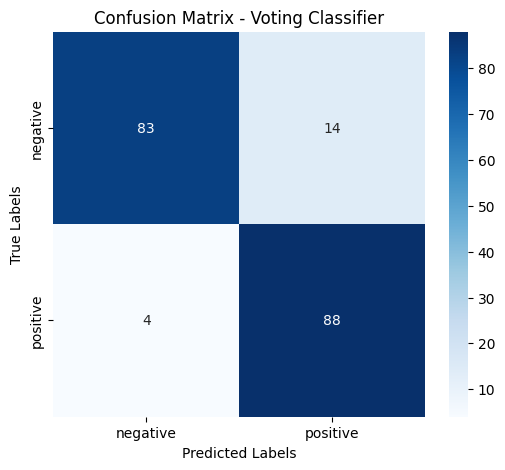


=== Stacking Classifier ===
📦 Model Stacking Classifier disimpan: model_stacking_classifier.pkl
✅ Akurasi Stacking Classifier: 0.91005291005291

Classification Report Stacking Classifier:
              precision    recall  f1-score   support
0               0.9545    0.8660    0.9081   97.0000
1               0.8713    0.9565    0.9119   92.0000
accuracy      0.910053  0.910053  0.910053  0.910053
macro avg       0.9129    0.9113    0.9100  189.0000
weighted avg    0.9140    0.9101    0.9100  189.0000


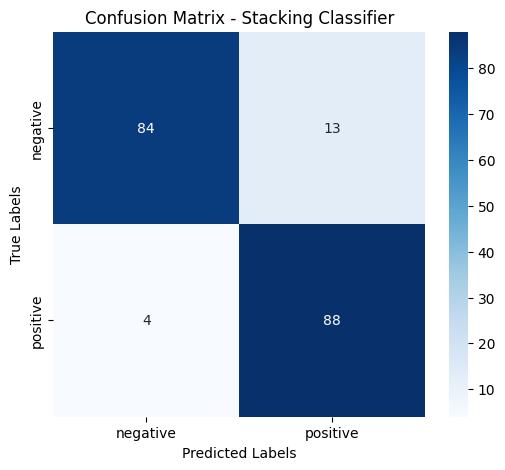


=== DES KNORA-E ===


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


📦 Model DES KNORA-E disimpan: model_des_knorae.pkl
✅ Akurasi DES KNORA-E: 0.8994708994708994

Classification Report DES KNORA-E:
              precision    recall  f1-score   support
0               0.9432    0.8557    0.8973   97.0000
1               0.8614    0.9457    0.9016   92.0000
accuracy      0.899471  0.899471  0.899471  0.899471
macro avg       0.9023    0.9007    0.8994  189.0000
weighted avg    0.9034    0.8995    0.8994  189.0000


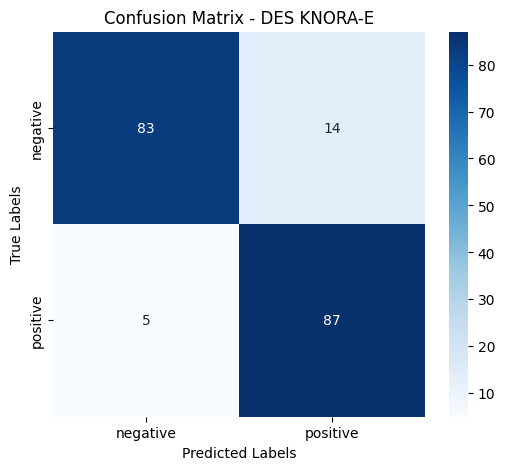

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump
from deslib.des.knora_e import KNORAE  # Import KNORA-E from DESlib
import scipy.sparse # Import scipy.sparse

# === GridSearch untuk tuning SVM ===
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # hanya untuk kernel non-linear
}

grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print("Best Parameters SVM:", grid_search_svm.best_params_)

# Inisialisasi model SVM dengan best params dari GridSearch
best_svm_params = grid_search_svm.best_params_
svm_model = SVC(
    probability=True,
    C=best_svm_params['C'],
    kernel=best_svm_params['kernel'],
    gamma=best_svm_params['gamma'],
    random_state=42
)

# === GridSearch untuk tuning Logistic Regression ===
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search_lr = GridSearchCV(logreg, param_grid_lr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best Parameters Logistic Regression:", grid_search_lr.best_params_)

# Inisialisasi model Logistic Regression dengan best params dari GridSearch
best_lr_params = grid_search_lr.best_params_
lr_model = LogisticRegression(
    C=best_lr_params['C'],
    penalty=best_lr_params['penalty'],
    solver=best_lr_params['solver'],
    max_iter=best_lr_params['max_iter'],
    random_state=42
)

# Inisialisasi model Naive Bayes
nb_model = MultinomialNB()

# === Fit the models individually before using them in KNORA-E ===
# These fits were done for the first time here, needed before creating the DES object
svm_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# === VotingClassifier ===
voting_clf = VotingClassifier(
    estimators=[('svm', svm_model), ('nb', nb_model), ('lr', lr_model)],
    voting='soft'
)

# === StackingClassifier ===
stacking_clf = StackingClassifier(
    estimators=[('svm', svm_model), ('nb', nb_model), ('lr', lr_model)],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5
)

# === Dynamic Ensemble Selection (DES) ===
# KNORA-E (K Nearest Optimal Classifier - Ensemble)
# Pass the already fitted models to the DES constructor
des_knorae = KNORAE(pool_classifiers=[svm_model, nb_model, lr_model], k=5)

# Daftar model untuk evaluasi
models = {
    'Voting Classifier': voting_clf,
    'Stacking Classifier': stacking_clf,
    'DES KNORA-E': des_knorae
}

# Jika X_train dan X_test berupa sparse matrix, ubah menjadi dense
X_train_dense = X_train.toarray() if isinstance(X_train, pd.DataFrame) or isinstance(X_train, scipy.sparse.spmatrix) else X_train
X_test_dense = X_test.toarray() if isinstance(X_test, pd.DataFrame) or isinstance(X_test, scipy.sparse.spmatrix) else X_test

# Latih dan evaluasi setiap model
for name, model in models.items():
    print(f"\n=== {name} ===")

    # For DES models, fit requires X_train_dense and y_train
    if name == 'DES KNORA-E':
        model.fit(X_train_dense, y_train)
    else:
        # Other models can be fitted on sparse or dense depending on their support.
        # Since we converted to dense for DES, let's use dense for consistency
        # or revert to sparse if the model supports it and it's more efficient.
        # Based on the error, it seems like DES needed dense, so let's stick with dense for fitting here too.
        # However, re-fitting models that were already tuned and fitted on sparse X_train
        # might slightly change their performance compared to the GridSearchCV results.
        # A better approach for DES with sparse data is complex and depends on the DES method.
        # For simplicity and to fix the immediate error, we refit on dense.
        # If performance drops, consider a DES method that supports sparse data or a different approach.
         model.fit(X_train_dense, y_train) # Re-fit on dense data for uniformity

    # Prediksi dan evaluasi pada test set
    # Prediction for all models will use the dense test data
    y_pred = model.predict(X_test_dense)
    acc = accuracy_score(y_test, y_pred)

    # Simpan model ke file
    # Ensure 'models' directory exists if you want to save there
    # import os
    # os.makedirs('models', exist_ok=True)
    model_filename = f"model_{name.lower().replace(' ', '_').replace('-', '')}.pkl" # Clean up name for filename
    dump(model, model_filename)
    print(f"📦 Model {name} disimpan: {model_filename}")

    # Tampilkan akurasi dan classification report
    print(f"✅ Akurasi {name}: {acc}")

    # Classification report dengan format 4 angka dibelakang koma
    report = classification_report(y_test, y_pred, output_dict=True)

    # Format angka dengan 4 angka di belakang koma
    for label in report:
        if label != 'accuracy':  # Tidak perlu format untuk accuracy
            for metric in report[label]:
                report[label][metric] = f"{report[label][metric]:.4f}"

    # Tampilkan classification report dengan format yang sudah diubah
    print(f"\nClassification Report {name}:\n", pd.DataFrame(report).transpose())

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred) # Use y_test and y_pred for correct matrix calculation
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['negative', 'positive'],
                yticklabels=['negative', 'positive'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Labels") # Corrected label
    plt.ylabel("True Labels") # Corrected label
    plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
🎯 Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
🎯 Best CV Score: 0.9019
✅ Akurasi Data Latih: 0.9735
✅ Akurasi Data Uji: 0.8571
Classification Report (Data Uji):
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        97
           1       0.87      0.83      0.85        92

    accuracy                           0.86       189
   macro avg       0.86      0.86      0.86       189
weighted avg       0.86      0.86      0.86       189



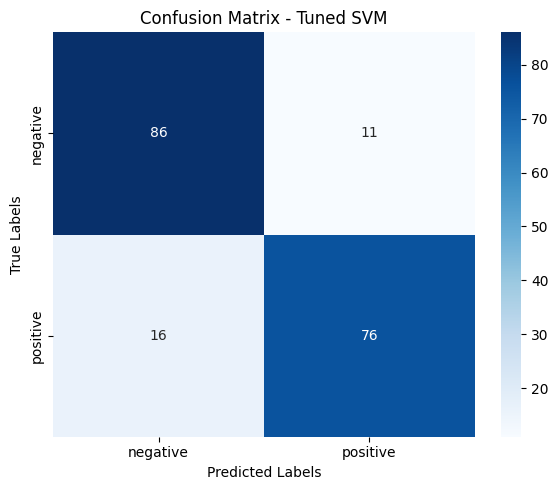

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump

# ==== Hyperparameter tuning dengan GridSearchCV ====
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # hanya untuk kernel non-linear
}

grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print(f"🎯 Best Parameters: {grid_search.best_params_}")
print(f"🎯 Best CV Score: {grid_search.best_score_:.4f}")

# Menggunakan model terbaik
svm_model = grid_search.best_estimator_

# Evaluasi pada data latih
svm_train_pred = svm_model.predict(X_train)
svm_train_acc = accuracy_score(y_train, svm_train_pred)


# Evaluasi pada data uji
svm_test_pred = svm_model.predict(X_test)
svm_test_acc = accuracy_score(y_test, svm_test_pred)

# Simpan model
dump(svm_model, 'model_svm_tuned.pkl')

# Output akurasi
print(f"✅ Akurasi Data Latih: {svm_train_acc:.4f}")
print(f"✅ Akurasi Data Uji: {svm_test_acc:.4f}")

# Classification report dan confusion matrix
print("Classification Report (Data Uji):")
print(classification_report(y_test, svm_test_pred))

cm_svm = confusion_matrix(y_test, svm_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative',  'positive'],
            yticklabels=['negative',  'positive'])
plt.title("Confusion Matrix - Tuned SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


📦 Model Naive Bayes Multinomial disimpan: model_nb_multinomial.pkl
✅ Akurasi Naive Bayes: 0.8624338624338624
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        97
           1       0.86      0.86      0.86        92

    accuracy                           0.86       189
   macro avg       0.86      0.86      0.86       189
weighted avg       0.86      0.86      0.86       189



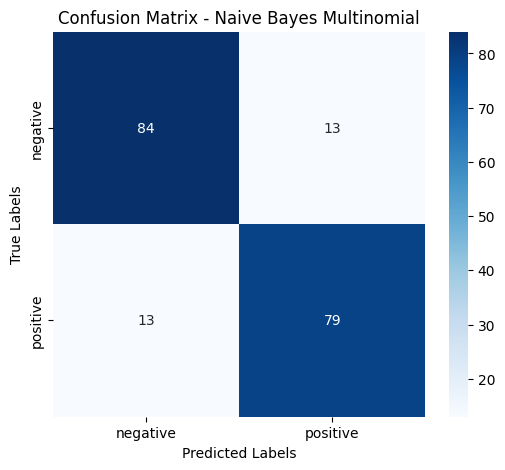

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# Inisialisasi model Naive Bayes Multinomial
nb_model = MultinomialNB()

# Latih model Naive Bayes
# Tidak perlu mengkonversi sparse matrix ke array, karena MultinomialNB dapat menangani sparse matrix
nb_model.fit(X_train, y_train)

# Prediksi dan evaluasi
nb_pred = nb_model.predict(X_test)
nb_acc = accuracy_score(y_test, nb_pred)

# Simpan model Naive Bayes ke file
# It's generally better practice to save models in a designated folder
# You might need to create the 'models' directory if it doesn't exist
# import os
# os.makedirs('models', exist_ok=True)
dump(nb_model, 'model_nb_Gaussian_tfidf.pkl')
print(f"📦 Model Naive Bayes Multinomial disimpan: model_nb_multinomial.pkl") # Updated path

# Tampilkan akurasi, classification report, dan confusion matrix
print(f"✅ Akurasi Naive Bayes: {nb_acc}")
print(classification_report(y_test, nb_pred))

# Plot confusion matrix
cm_nb = confusion_matrix(y_test, nb_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix - Naive Bayes Multinomial")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
🎯 Best Parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
🎯 Best CV Score: 0.9364
✅ Akurasi Data Latih: 0.9960
✅ Akurasi Data Uji: 0.8995
Classification Report (Data Uji):
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        97
           1       0.86      0.95      0.90        92

    accuracy                           0.90       189
   macro avg       0.90      0.90      0.90       189
weighted avg       0.90      0.90      0.90       189



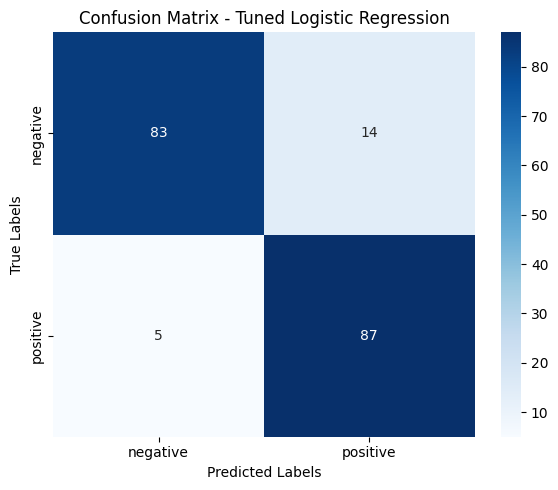

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump


# ==== Hyperparameter tuning dengan GridSearchCV ====
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print(f"🎯 Best Parameters: {grid_search.best_params_}")
print(f"🎯 Best CV Score: {grid_search.best_score_:.4f}")

# Menggunakan model terbaik
logreg_model = grid_search.best_estimator_

# Evaluasi pada data latih
logreg_train_pred = logreg_model.predict(X_train)
logreg_train_acc = accuracy_score(y_train, logreg_train_pred)


# Evaluasi pada data uji
logreg_test_pred = logreg_model.predict(X_test)
logreg_test_acc = accuracy_score(y_test, logreg_test_pred)

# Simpan model
dump(logreg_model, 'model_logreg_tuned.pkl')

# Output akurasi
print(f"✅ Akurasi Data Latih: {logreg_train_acc:.4f}")
print(f"✅ Akurasi Data Uji: {logreg_test_acc:.4f}")

# Classification report dan confusion matrix
print("Classification Report (Data Uji):")
print(classification_report(y_test, logreg_test_pred))

cm_logreg = confusion_matrix(y_test, logreg_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


In [4]:

!pip install deslib==0.3.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.6/172.6 kB 3.4 MB/s eta 0:00:00


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters Logistic Regression: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

=== Voting Classifier ===
📦 Model Voting Classifier disimpan: model_voting_classifier.pkl
✅ Akurasi Voting Classifier: 0.91005291005291

Classification Report Voting Classifier:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91        97
           1       0.86      0.97      0.91        92

    accuracy                           0.91       189
   macro avg       0.91      0.91      0.91       189
weighted avg       0.92      0.91      0.91       189



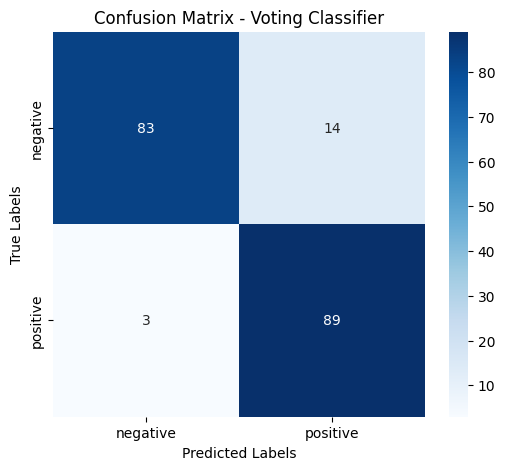


=== Stacking Classifier ===
📦 Model Stacking Classifier disimpan: model_stacking_classifier.pkl
✅ Akurasi Stacking Classifier: 0.91005291005291

Classification Report Stacking Classifier:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91        97
           1       0.87      0.96      0.91        92

    accuracy                           0.91       189
   macro avg       0.91      0.91      0.91       189
weighted avg       0.91      0.91      0.91       189



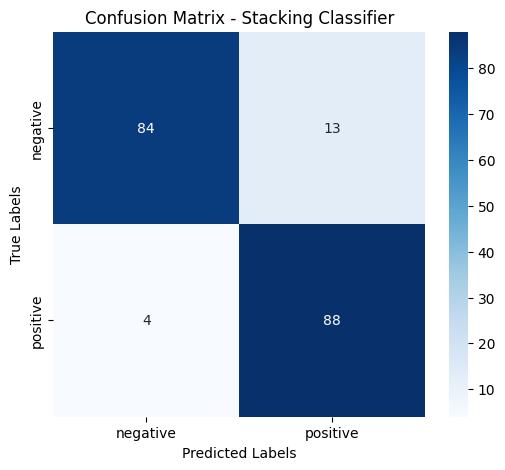


=== DES KNORA-E ===


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


📦 Model DES KNORA-E disimpan: model_des_knorae.pkl
✅ Akurasi DES KNORA-E: 0.8994708994708994

Classification Report DES KNORA-E:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90        97
           1       0.86      0.95      0.90        92

    accuracy                           0.90       189
   macro avg       0.90      0.90      0.90       189
weighted avg       0.90      0.90      0.90       189



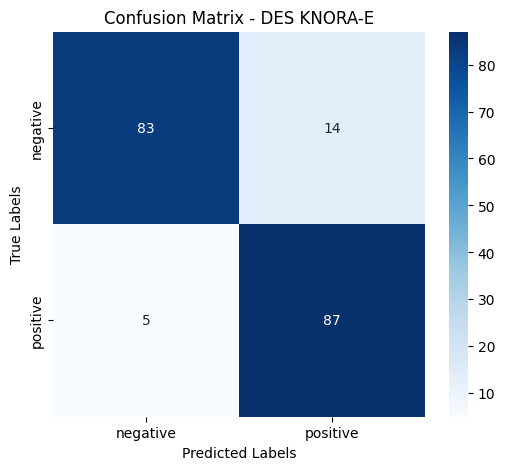

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump
from deslib.des.knora_e import KNORAE  # Import KNORA-E from DESlib
import scipy.sparse # Import scipy.sparse

# === GridSearch untuk tuning SVM ===
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # hanya untuk kernel non-linear
}

grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print("Best Parameters SVM:", grid_search_svm.best_params_)

# Inisialisasi model SVM dengan best params dari GridSearch
best_svm_params = grid_search_svm.best_params_
svm_model = SVC(
    probability=True,
    C=best_svm_params['C'],
    kernel=best_svm_params['kernel'],
    gamma=best_svm_params['gamma'],
    random_state=42
)

# === GridSearch untuk tuning Logistic Regression ===
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search_lr = GridSearchCV(logreg, param_grid_lr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best Parameters Logistic Regression:", grid_search_lr.best_params_)

# Inisialisasi model Logistic Regression dengan best params dari GridSearch
best_lr_params = grid_search_lr.best_params_
lr_model = LogisticRegression(
    C=best_lr_params['C'],
    penalty=best_lr_params['penalty'],
    solver=best_lr_params['solver'],
    max_iter=best_lr_params['max_iter'],
    random_state=42
)

# Inisialisasi model Naive Bayes
nb_model = MultinomialNB()

# === Fit the models individually before using them in KNORA-E ===
# These fits were done for the first time here, needed before creating the DES object
svm_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)


# === VotingClassifier ===
voting_clf = VotingClassifier(
    estimators=[('svm', svm_model), ('nb', nb_model), ('lr', lr_model)],
    voting='soft'
)

# === StackingClassifier ===
stacking_clf = StackingClassifier(
    estimators=[('svm', svm_model), ('nb', nb_model), ('lr', lr_model)],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5
)

# === Dynamic Ensemble Selection (DES) ===
# KNORA-E (K Nearest Optimal Classifier - Ensemble)
# Pass the already fitted models to the DES constructor
des_knorae = KNORAE(pool_classifiers=[svm_model, nb_model, lr_model], k=5)

# Daftar model untuk evaluasi
models = {
    'Voting Classifier': voting_clf,
    'Stacking Classifier': stacking_clf,
    'DES KNORA-E': des_knorae
}

# Jika X_train dan X_test berupa sparse matrix, ubah menjadi dense
X_train_dense = X_train.toarray() if isinstance(X_train, pd.DataFrame) or isinstance(X_train, scipy.sparse.spmatrix) else X_train
X_test_dense = X_test.toarray() if isinstance(X_test, pd.DataFrame) or isinstance(X_test, scipy.sparse.spmatrix) else X_test


# Latih dan evaluasi setiap model
for name, model in models.items():
    print(f"\n=== {name} ===")

    # For DES models, fit requires X_train_dense and y_train
    if name == 'DES KNORA-E':
        model.fit(X_train_dense, y_train)
    else:
        # Other models can be fitted on sparse or dense depending on their support.
        # Since we converted to dense for DES, let's use dense for consistency
        # or revert to sparse if the model supports it and it's more efficient.
        # Based on the error, it seems like DES needed dense, so let's stick with dense for fitting here too.
        # However, re-fitting models that were already tuned and fitted on sparse X_train
        # might slightly change their performance compared to the GridSearchCV results.
        # A better approach for DES with sparse data is complex and depends on the DES method.
        # For simplicity and to fix the immediate error, we refit on dense.
        # If performance drops, consider a DES method that supports sparse data or a different approach.
         model.fit(X_train_dense, y_train) # Re-fit on dense data for uniformity

    # Prediksi dan evaluasi pada test set
    # Prediction for all models will use the dense test data
    y_pred = model.predict(X_test_dense)
    acc = accuracy_score(y_test, y_pred)

    # Simpan model ke file
    # Ensure 'models' directory exists if you want to save there
    # import os
    # os.makedirs('models', exist_ok=True)
    model_filename = f"model_{name.lower().replace(' ', '_').replace('-', '')}.pkl" # Clean up name for filename
    dump(model, model_filename)
    print(f"📦 Model {name} disimpan: {model_filename}")

    # Tampilkan akurasi dan classification report
    print(f"✅ Akurasi {name}: {acc}")
    print(f"\nClassification Report {name}:\n", classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred) # Use y_test and y_pred for correct matrix calculation
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['negative', 'positive'],
                yticklabels=['negative', 'positive'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Labels") # Corrected label
    plt.ylabel("True Labels") # Corrected label
    plt.show()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters Logistic Regression: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
📦 Model Voting Classifier disimpan: model_voting.pkl
✅ Akurasi Voting Classifier: 0.8941798941798942
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        91
           1       0.91      0.89      0.90        98

    accuracy                           0.89       189
   macro avg       0.89      0.89      0.89       189
weighted avg       0.89      0.89      0.89       189



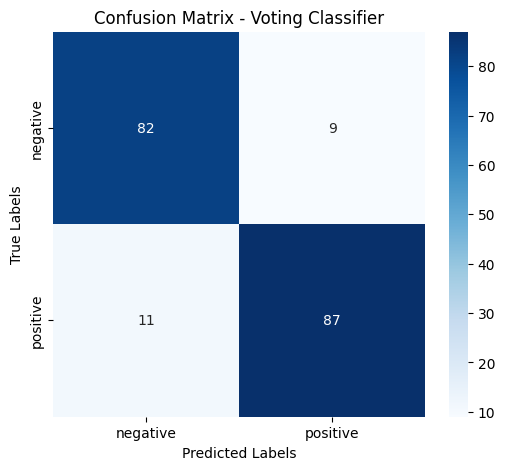

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# === GridSearch untuk tuning SVM ===
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # hanya untuk kernel non-linear
}

grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print("Best Parameters SVM:", grid_search_svm.best_params_)

# Inisialisasi model SVM dengan best params dari GridSearch
best_svm_params = grid_search_svm.best_params_
svm_model = SVC(
    probability=True,
    C=best_svm_params['C'],
    kernel=best_svm_params['kernel'],
    gamma=best_svm_params['gamma']
)

# === GridSearch untuk tuning Logistic Regression ===
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search_lr = GridSearchCV(logreg, param_grid_lr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best Parameters Logistic Regression:", grid_search_lr.best_params_)

# Inisialisasi model Logistic Regression dengan best params dari GridSearch
best_lr_params = grid_search_lr.best_params_
lr_model = LogisticRegression(
    C=best_lr_params['C'],
    penalty=best_lr_params['penalty'],
    solver=best_lr_params['solver'],
    max_iter=best_lr_params['max_iter']
)

# Inisialisasi model Naive Bayes
nb_model = MultinomialNB()

# Voting classifier dengan 3 model dan bobot
voting_clf = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('nb', nb_model),
        ('lr', lr_model)
    ],
    voting='soft',

)

# Latih Voting Classifier
voting_clf.fit(X_train, y_train)

# Prediksi dan evaluasi
voting_pred = voting_clf.predict(X_test)
voting_acc = accuracy_score(y_test, voting_pred)

# Simpan model Voting Classifier ke file
dump(voting_clf, 'model_voting.pkl')
print(f"📦 Model Voting Classifier disimpan: model_voting.pkl")

# Tampilkan akurasi, classification report, dan confusion matrix
print(f"✅ Akurasi Voting Classifier: {voting_acc}")
print(classification_report(y_test, voting_pred))

# Plot confusion matrix
cm_voting = confusion_matrix(y_test, voting_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_voting, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative',  'positive'],
            yticklabels=['negative',  'positive'])
plt.title("Confusion Matrix - Voting Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters Logistic Regression: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
📦 Model Voting Classifier disimpan: model_voting.pkl
✅ Akurasi Voting Classifier: 0.8888888888888888
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        91
           1       0.91      0.88      0.89        98

    accuracy                           0.89       189
   macro avg       0.89      0.89      0.89       189
weighted avg       0.89      0.89      0.89       189



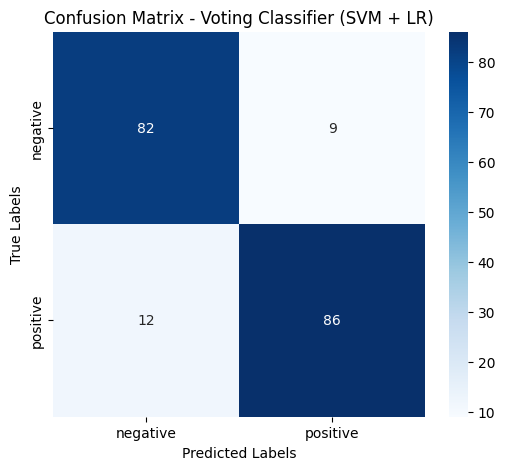

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# === GridSearch untuk tuning SVM ===
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print("Best Parameters SVM:", grid_search_svm.best_params_)

best_svm_params = grid_search_svm.best_params_
svm_model = SVC(
    probability=True,
    C=best_svm_params['C'],
    kernel=best_svm_params['kernel'],
    gamma=best_svm_params['gamma']
)

# === GridSearch untuk Logistic Regression ===
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [100, 200]
}

logreg = LogisticRegression()
grid_search_lr = GridSearchCV(logreg, param_grid_lr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best Parameters Logistic Regression:", grid_search_lr.best_params_)

best_lr_params = grid_search_lr.best_params_
lr_model = LogisticRegression(
    C=best_lr_params['C'],
    penalty=best_lr_params['penalty'],
    solver=best_lr_params['solver'],
    max_iter=best_lr_params['max_iter']
)

# Voting classifier hanya dengan SVM dan Logistic Regression
voting_clf = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('lr', lr_model)
    ],
    voting='soft',

)

# Latih Voting Classifier
voting_clf.fit(X_train, y_train)

# Prediksi dan evaluasi
voting_pred = voting_clf.predict(X_test)
voting_acc = accuracy_score(y_test, voting_pred)

# Simpan model Voting Classifier
dump(voting_clf, 'model_voting.pkl')
print(f"📦 Model Voting Classifier disimpan: model_voting.pkl")

# Tampilkan hasil evaluasi
print(f"✅ Akurasi Voting Classifier: {voting_acc}")
print(classification_report(y_test, voting_pred))

# Plot confusion matrix
cm_voting = confusion_matrix(y_test, voting_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_voting, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative',  'positive'],
            yticklabels=['negative',  'positive'])
plt.title("Confusion Matrix - Voting Classifier (SVM + LR)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters Logistic Regression: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
📦 Model Voting Classifier disimpan: model_voting.pkl
✅ Akurasi Voting Classifier: 0.9206349206349206
              precision    recall  f1-score   support

           0       0.96      0.87      0.91        91
           1       0.89      0.97      0.93        98

    accuracy                           0.92       189
   macro avg       0.93      0.92      0.92       189
weighted avg       0.92      0.92      0.92       189



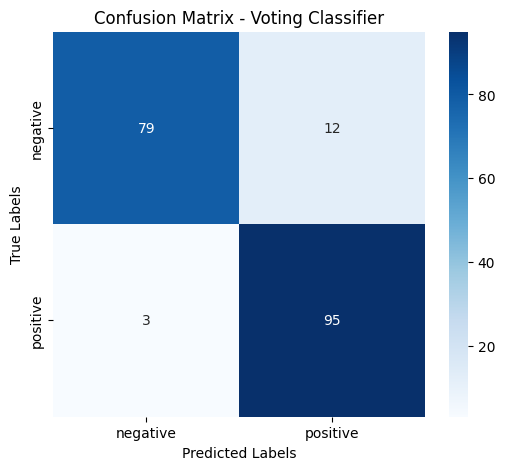

In [ ]:
from sklearn.ensemble import VotingClassifier
#from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump


# === GridSearch untuk tuning Logistic Regression ===
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search_lr = GridSearchCV(logreg, param_grid_lr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best Parameters Logistic Regression:", grid_search_lr.best_params_)

# Inisialisasi model Logistic Regression dengan best params dari GridSearch
best_lr_params = grid_search_lr.best_params_
lr_model = LogisticRegression(
    C=best_lr_params['C'],
    penalty=best_lr_params['penalty'],
    solver=best_lr_params['solver'],
    max_iter=best_lr_params['max_iter']
)

# Inisialisasi model Naive Bayes
nb_model = MultinomialNB()

# Voting classifier dengan 3 model dan bobot
voting_clf = VotingClassifier(
    estimators=[

        ('nb', nb_model),
        ('lr', lr_model)
    ],
    voting='soft',

)

# Latih Voting Classifier
voting_clf.fit(X_train, y_train)

# Prediksi dan evaluasi
voting_pred = voting_clf.predict(X_test)
voting_acc = accuracy_score(y_test, voting_pred)

# Simpan model Voting Classifier ke file
dump(voting_clf, 'model_voting.pkl')
print(f"📦 Model Voting Classifier disimpan: model_voting.pkl")

# Tampilkan akurasi, classification report, dan confusion matrix
print(f"✅ Akurasi Voting Classifier: {voting_acc}")
print(classification_report(y_test, voting_pred))

# Plot confusion matrix
cm_voting = confusion_matrix(y_test, voting_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_voting, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative',  'positive'],
            yticklabels=['negative',  'positive'])
plt.title("Confusion Matrix - Voting Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


- Menampilkan Wordcloud dari kelas positif dan kelas negatif

In [ ]:
df_positif = df[df['truth_label'] == 'positive']

In [ ]:
df_negatif = df[df['truth_label'] == 'negative']

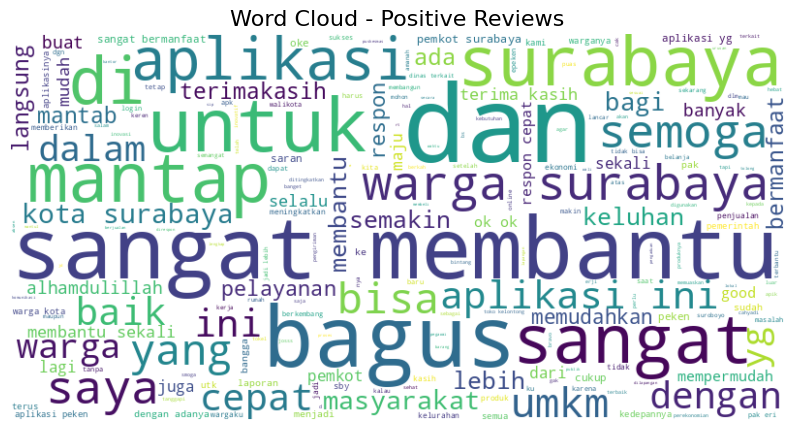

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract text from df_positif['ulasan']
positive_text = ' '.join(df_positif['ulasan'].dropna())  # Join all positive reviews into one large string

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud - Positive Reviews', fontsize=16)
plt.show()

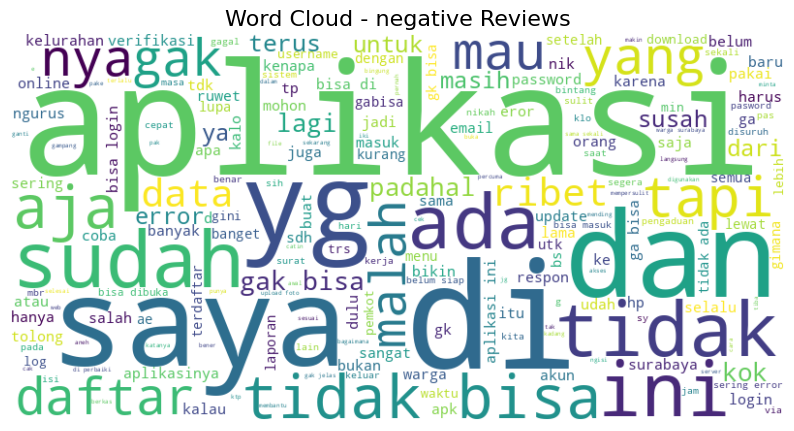

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract text from df_positif['ulasan']
negative_text = ' '.join(df_negatif['ulasan'].dropna())  # Join all positive reviews into one large string

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud - negative Reviews', fontsize=16)
plt.show()

# FASTTEXT fitur ekstaksi

In [1]:
import pandas as pd

file_path = 'df_manual.csv'  # Ganti dengan path file Anda
df = pd.read_csv(file_path, sep=';', on_bad_lines='skip')

In [2]:
df = df[df['truth_label'] != 'neutral']

In [3]:
df.columns

Index(['ulasan', 'truth_label', 'confidence'], dtype='object')

In [5]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
!gunzip cc.id.300.vec.gz

--2025-07-24 11:32:24--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.13, 3.171.22.68, 3.171.22.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227018698 (1.1G) [binary/octet-stream]
Saving to: ‘cc.id.300.vec.gz’

cc.id.300.vec.gz    100%[===================>]   1.14G   159MB/s    in 9.5s    

2025-07-24 11:32:34 (123 MB/s) - ‘cc.id.300.vec.gz’ saved [1227018698/1227018698]



In [6]:
!pip install gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

In [5]:
# Load FastText embeddings with gensim
import gensim
from gensim.models import KeyedVectors
fasttext_model = KeyedVectors.load_word2vec_format('cc.id.300.vec', binary=False)

In [6]:
import numpy as np

# Fungsi untuk mendapatkan rata-rata vektor kata dalam kalimat menggunakan FastText
def get_average_vector(text, model):
    words = text.split()  # Pisahkan kalimat menjadi kata-kata
    vectors = [model[word] for word in words if word in model]  # Ambil vektor untuk kata-kata yang ada di model
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)  # Hitung rata-rata vektor

# Mengubah data ulasan menjadi vektor
X_fasttext = df['ulasan'].apply(lambda x: get_average_vector(x, fasttext_model)).tolist()
X_fasttext = np.array(X_fasttext)  # Ubah menjadi array numpy untuk penggunaan lebih lanjut


In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode label sentimen menjadi angka
le = LabelEncoder()
y_labels = le.fit_transform(df['truth_label'])

In [8]:
from sklearn.model_selection import train_test_split
# Split pertama: training 80%, testing 20%
X_train, X_test, y_train, y_test = train_test_split(
    X_fasttext, y_labels, test_size=0.2, random_state=42
)

# Print ukuran data
print(f"Training data: {X_train.shape[0]}")    # ~80%
print(f"Testing data: {X_test.shape[0]}")      # ~20%

Training data: 754
Testing data: 189


In [9]:
df_embeddings = pd.DataFrame({
    'original_text': df['ulasan'],
    'fasttext_vector': X_fasttext.tolist()
})

# Now you can access both the original text and the embedding
print(df_embeddings.head())

                                        original_text  \
0   tidak bisa verifikasi akun lewat wa selalu ero...   
1                                     Sangat membantu   
5   aplikasi tidak bisa di kliktidak bisa di buka ...   
11  aplikasi g jelasblm pernah daftar tp keteranga...   
15             pada saat buka alplikask wargaku muter   

                                      fasttext_vector  
0   [0.001046153949573636, 0.04228461533784866, -0...  
1   [0.007949999533593655, 0.021250000223517418, -...  
5   [0.022069232538342476, 0.0069461544044315815, ...  
11  [0.03345555439591408, 0.02952221967279911, 0.0...  
15  [0.03466000035405159, 0.01388000138103962, 0.0...  


In [10]:
df_embeddings

,original_text,fasttext_vector
0,tidak bisa verifikasi akun lewat wa selalu ero...,"[0.001046153949573636, 0.04228461533784866, -0..."
1,Sangat membantu,"[0.007949999533593655, 0.021250000223517418, -..."
5,aplikasi tidak bisa di kliktidak bisa di buka ...,"[0.022069232538342476, 0.0069461544044315815, ..."
11,aplikasi g jelasblm pernah daftar tp keteranga...,"[0.03345555439591408, 0.02952221967279911, 0.0..."
15,pada saat buka alplikask wargaku muter,"[0.03466000035405159, 0.01388000138103962, 0.0..."
...,...,...
998,sapu jagat sngat baik sekali,"[0.0026199999265372753, -0.042799998074769974,..."
999,mantap wis semoga fitur nya ditambah terutama ...,"[0.016115788370370865, -0.015521052293479443, ..."
1000,mantap,"[-0.07909999787807465, -0.04410000145435333, 0..."
1001,sangat bagus dan bermanfaat untuk mempermudah ...,"[-0.015933332964777946, -0.0003222214581910521..."


Fitting 5 folds for each of 12 candidates, totalling 60 fits
🎯 Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
🎯 Best CV Score: 0.9310
✅ Akurasi Data Latih: 0.9881
✅ Akurasi Data Uji: 0.9418

Classification Report (Data Uji):
             precision    recall  f1-score   support
0               0.9574    0.9278    0.9424   97.0000
1               0.9263    0.9565    0.9412   92.0000
accuracy      0.941799  0.941799  0.941799  0.941799
macro avg       0.9419    0.9422    0.9418  189.0000
weighted avg    0.9423    0.9418    0.9418  189.0000


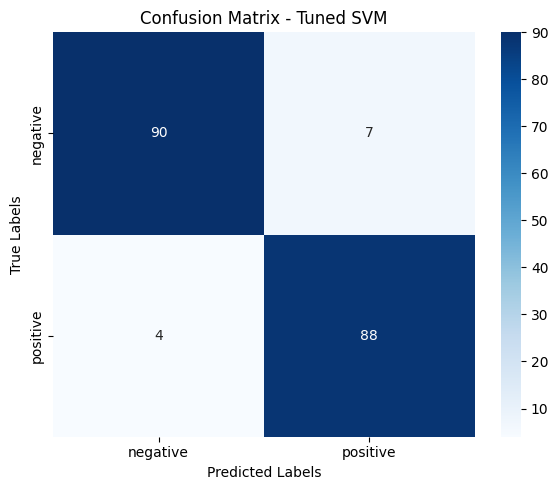

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump

# ==== Hyperparameter tuning dengan GridSearchCV ====
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # hanya untuk kernel non-linear
}

grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)  # Menggunakan X_train dan y_train yang sudah dipisahkan

# Menampilkan parameter terbaik
print(f"🎯 Best Parameters: {grid_search.best_params_}")
print(f"🎯 Best CV Score: {grid_search.best_score_:.4f}")

# Menggunakan model terbaik
svm_model = grid_search.best_estimator_

# Evaluasi pada data latih
svm_train_pred = svm_model.predict(X_train)
svm_train_acc = accuracy_score(y_train, svm_train_pred)

# Evaluasi pada data uji
svm_test_pred = svm_model.predict(X_test)
svm_test_acc = accuracy_score(y_test, svm_test_pred)

# Simpan model
dump(svm_model, 'model_svm_tuned.pkl')

# Output akurasi
print(f"✅ Akurasi Data Latih: {svm_train_acc:.4f}")
print(f"✅ Akurasi Data Uji: {svm_test_acc:.4f}")

# Classification report dengan format 4 angka dibelakang koma
report = classification_report(y_test, svm_test_pred, output_dict=True)

# Format angka dengan 4 angka di belakang koma
for label in report:
    if label != 'accuracy':  # Tidak perlu format untuk accuracy
        for metric in report[label]:
            report[label][metric] = f"{report[label][metric]:.4f}"

# Tampilkan classification report dengan format yang sudah diubah
print("\nClassification Report (Data Uji):")
print(pd.DataFrame(report).transpose())

# Confusion matrix
cm_svm = confusion_matrix(y_test, svm_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix - Tuned SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


📦 Model Naive Bayes Gaussian disimpan: model_nb_Gaussian_Fasttext.pkl
✅ Akurasi Naive Bayes: 0.6190476190476191

Classification Report (Data Uji):
             precision    recall  f1-score   support
0               0.5850    0.8866    0.7049   97.0000
1               0.7381    0.3370    0.4627   92.0000
accuracy      0.619048  0.619048  0.619048  0.619048
macro avg       0.6616    0.6118    0.5838  189.0000
weighted avg    0.6595    0.6190    0.5870  189.0000


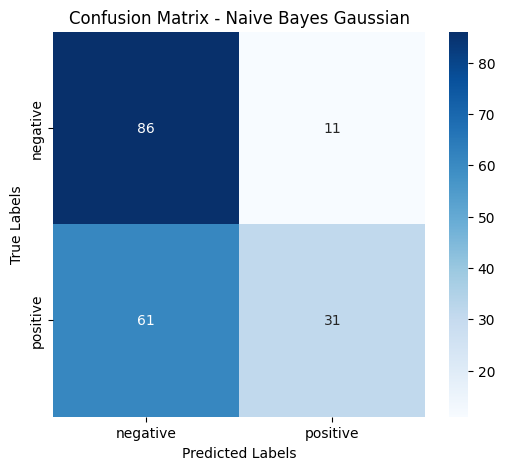

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# Inisialisasi model Naive Bayes Gaussian
nb_model = GaussianNB()

# Latih model Naive Bayes
nb_model.fit(X_train, y_train)  # Gunakan X_train dan y_train yang sudah di-split dengan FastText

# Prediksi dan evaluasi
nb_pred = nb_model.predict(X_test)  # Gunakan X_test dan y_test yang sudah di-split dengan FastText
nb_acc = accuracy_score(y_test, nb_pred)

# Simpan model Naive Bayes ke file
dump(nb_model, 'model_nb_Gaussian.pkl')
print(f"📦 Model Naive Bayes Gaussian disimpan: model_nb_Gaussian_Fasttext.pkl")

# Output akurasi
print(f"✅ Akurasi Naive Bayes: {nb_acc}")

# Classification report dengan format 4 angka dibelakang koma
report = classification_report(y_test, nb_pred, output_dict=True)

# Format angka dengan 4 angka di belakang koma
for label in report:
    if label != 'accuracy':  # Tidak perlu format untuk accuracy
        for metric in report[label]:
            report[label][metric] = f"{report[label][metric]:.4f}"

# Tampilkan classification report dengan format yang sudah diubah
print("\nClassification Report (Data Uji):")
print(pd.DataFrame(report).transpose())

# Plot confusion matrix
cm_nb = confusion_matrix(y_test, nb_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix - Naive Bayes Gaussian")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
🎯 Best Parameters: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
🎯 Best CV Score: 0.9244
✅ Akurasi Data Latih: 0.9801
✅ Akurasi Data Uji: 0.9471

Classification Report (Data Uji):
             precision   recall f1-score   support
0               0.9579   0.9381   0.9479   97.0000
1               0.9362   0.9565   0.9462   92.0000
accuracy       0.94709  0.94709  0.94709   0.94709
macro avg       0.9470   0.9473   0.9471  189.0000
weighted avg    0.9473   0.9471   0.9471  189.0000


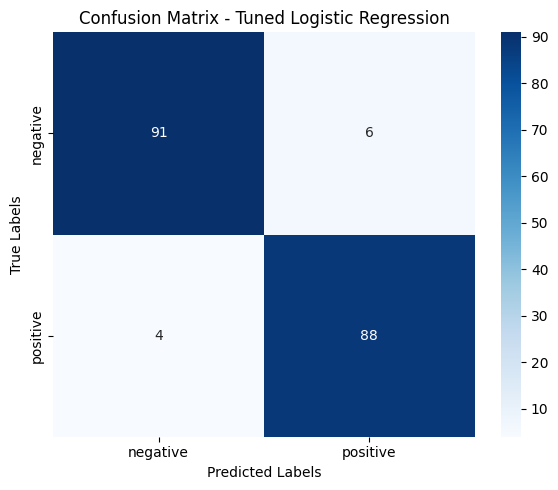

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump

# ==== Hyperparameter tuning dengan GridSearchCV ====
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print(f"🎯 Best Parameters: {grid_search.best_params_}")
print(f"🎯 Best CV Score: {grid_search.best_score_:.4f}")

# Menggunakan model terbaik
logreg_model = grid_search.best_estimator_

# Evaluasi pada data latih
logreg_train_pred = logreg_model.predict(X_train)
logreg_train_acc = accuracy_score(y_train, logreg_train_pred)

# Evaluasi pada data uji
logreg_test_pred = logreg_model.predict(X_test)
logreg_test_acc = accuracy_score(y_test, logreg_test_pred)

# Simpan model
dump(logreg_model, 'model_logreg_tuned.pkl')

# Output akurasi
print(f"✅ Akurasi Data Latih: {logreg_train_acc:.4f}")
print(f"✅ Akurasi Data Uji: {logreg_test_acc:.4f}")

# Classification report dengan format 4 angka dibelakang koma
report = classification_report(y_test, logreg_test_pred, output_dict=True)

# Format angka dengan 4 angka di belakang koma
for label in report:
    if label != 'accuracy':  # Tidak perlu format untuk accuracy
        for metric in report[label]:
            report[label][metric] = f"{report[label][metric]:.4f}"

# Tampilkan classification report dengan format yang sudah diubah
print("\nClassification Report (Data Uji):")
print(pd.DataFrame(report).transpose())

# Confusion matrix
cm_logreg = confusion_matrix(y_test, logreg_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters Logistic Regression: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

=== Voting Classifier ===
📦 Model Voting Classifier disimpan: model_voting_classifier.pkl
✅ Akurasi Voting Classifier: 0.9153439153439153

Classification Report Voting Classifier:
              precision    recall  f1-score   support
0               0.8932    0.9485    0.9200   97.0000
1               0.9419    0.8804    0.9101   92.0000
accuracy      0.915344  0.915344  0.915344  0.915344
macro avg       0.9175    0.9144    0.9151  189.0000
weighted avg    0.9169    0.9153    0.9152  189.0000


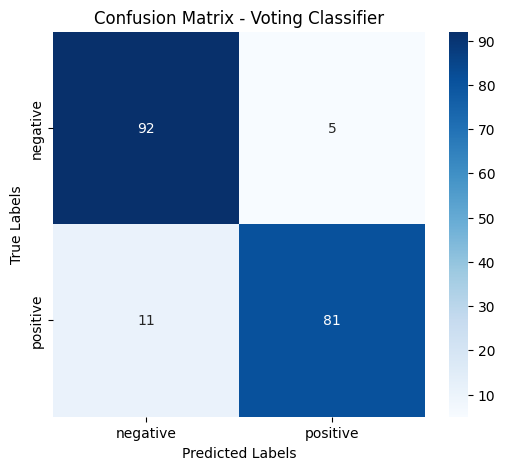


=== Stacking Classifier ===
📦 Model Stacking Classifier disimpan: model_stacking_classifier.pkl
✅ Akurasi Stacking Classifier: 0.9470899470899471

Classification Report Stacking Classifier:
              precision   recall f1-score   support
0               0.9579   0.9381   0.9479   97.0000
1               0.9362   0.9565   0.9462   92.0000
accuracy       0.94709  0.94709  0.94709   0.94709
macro avg       0.9470   0.9473   0.9471  189.0000
weighted avg    0.9473   0.9471   0.9471  189.0000


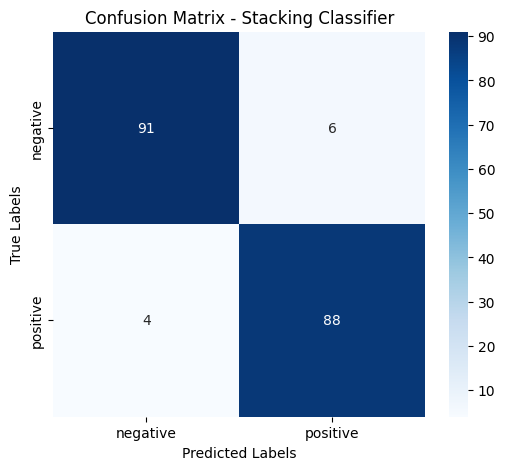


=== DES KNORA-E ===


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


📦 Model DES KNORA-E disimpan: model_des_knora-e.pkl
✅ Akurasi DES KNORA-E: 0.9470899470899471

Classification Report DES KNORA-E:
              precision   recall f1-score   support
0               0.9579   0.9381   0.9479   97.0000
1               0.9362   0.9565   0.9462   92.0000
accuracy       0.94709  0.94709  0.94709   0.94709
macro avg       0.9470   0.9473   0.9471  189.0000
weighted avg    0.9473   0.9471   0.9471  189.0000


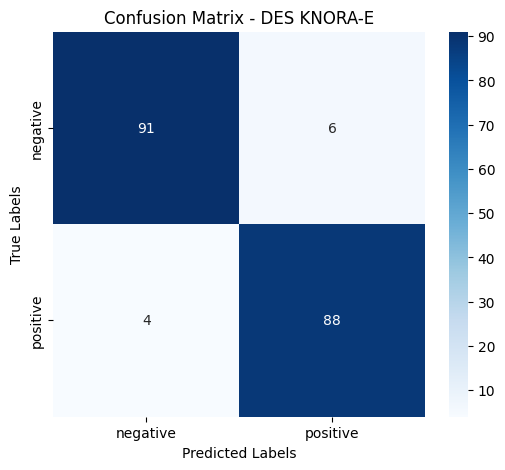

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump
from deslib.des.knora_e import KNORAE

# === GridSearch untuk tuning SVM ===
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # hanya untuk kernel non-linear
}

grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print("Best Parameters SVM:", grid_search_svm.best_params_)

# Inisialisasi model SVM dengan best params dari GridSearch
best_svm_params = grid_search_svm.best_params_
svm_model = SVC(
    probability=True,
    C=best_svm_params['C'],
    kernel=best_svm_params['kernel'],
    gamma=best_svm_params['gamma'],
    random_state=42
)

# === GridSearch untuk tuning Logistic Regression ===
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search_lr = GridSearchCV(logreg, param_grid_lr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best Parameters Logistic Regression:", grid_search_lr.best_params_)

# Inisialisasi model Logistic Regression dengan best params dari GridSearch
best_lr_params = grid_search_lr.best_params_
lr_model = LogisticRegression(
    C=best_lr_params['C'],
    penalty=best_lr_params['penalty'],
    solver=best_lr_params['solver'],
    max_iter=best_lr_params['max_iter'],
    random_state=42
)

# Inisialisasi model Naive Bayes
nb_model = GaussianNB()

# === Latih model terlebih dahulu sebelum digunakan di DES ===
svm_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# === VotingClassifier ===
voting_clf = VotingClassifier(
    estimators=[('svm', svm_model), ('nb', nb_model), ('lr', lr_model)],
    voting='soft'
)

# === StackingClassifier ===
stacking_clf = StackingClassifier(
    estimators=[('svm', svm_model), ('nb', nb_model), ('lr', lr_model)],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5
)

# === Dynamic Ensemble Selection (DES) ===
# KNORA-E (K Nearest Optimal Classifier - Ensemble)
des_knorae = KNORAE(pool_classifiers=[svm_model, nb_model, lr_model], k=5)

# Daftar model untuk evaluasi
models = {
    'Voting Classifier': voting_clf,
    'Stacking Classifier': stacking_clf,
    'DES KNORA-E': des_knorae
}

# Latih dan evaluasi setiap model
for name, model in models.items():
    print(f"\n=== {name} ===")

    # Latih model
    model.fit(X_train, y_train)

    # Prediksi dan evaluasi pada test set
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # Simpan model ke file
    model_filename = f"model_{name.lower().replace(' ', '_')}.pkl"
    dump(model, model_filename)
    print(f"📦 Model {name} disimpan: {model_filename}")

    # Output akurasi
    print(f"✅ Akurasi {name}: {acc}")

    # Classification report dengan format 4 angka dibelakang koma
    report = classification_report(y_test, y_pred, output_dict=True)

    # Format angka dengan 4 angka di belakang koma
    for label in report:
        if label != 'accuracy':  # Tidak perlu format untuk accuracy
            for metric in report[label]:
                report[label][metric] = f"{report[label][metric]:.4f}"

    # Tampilkan classification report dengan format yang sudah diubah
    print(f"\nClassification Report {name}:\n", pd.DataFrame(report).transpose())

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['negative', 'positive'],
                yticklabels=['negative', 'positive'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


In [ ]:
# Temukan index yang menunjukkan false negatives
false_negatives = (y_test == 1) & (y_pred == 0)

# Ambil data test yang false negative
false_negative_data = X_test[false_negatives]

In [ ]:
false_negative_data

array([[ 0.015     ,  0.11879999,  0.088     , ...,  0.07303333,
        -0.03206667, -0.04526667],
       [ 0.00760909,  0.00446364,  0.00648409, ..., -0.04899773,
        -0.01457046,  0.04952728],
       [ 0.0119    ,  0.00555556,  0.01215556, ..., -0.0113    ,
        -0.02587778,  0.07916667],
       [ 0.01318333,  0.035925  , -0.00818333, ..., -0.04714166,
        -0.0208    ,  0.0248    ]])

In [ ]:
df_embeddings

,original_text,fasttext_vector
0,tidak bisa verifikasi akun lewat wa selalu ero...,"[0.001046153949573636, 0.04228461533784866, -0..."
1,Sigap tanggap mengatasi keluhan,"[-0.010049999691545963, 0.0016499999910593033,..."
5,aplikasi tidak bisa di kliktidak bisa di buka ...,"[0.022069232538342476, 0.0069461544044315815, ..."
11,aplikasi g jelasblm pernah daftar tp keteranga...,"[0.03345555439591408, 0.02952221967279911, 0.0..."
15,pada saat buka alplikask wargaku muter,"[0.03466000035405159, 0.01388000138103962, 0.0..."
...,...,...
998,sapu jagat sngat baik sekali,"[0.0026199999265372753, -0.042799998074769974,..."
999,mantap wis semoga fitur nya ditambah terutama ...,"[0.016115788370370865, -0.015521052293479443, ..."
1000,mantap,"[-0.07909999787807465, -0.04410000145435333, 0..."
1001,sangat bagus dan bermanfaat untuk mempermudah ...,"[-0.015933332964777946, -0.0003222214581910521..."


In [ ]:
df_embeddings[df_embeddings['fasttext_vector'].isin(false_negative_data.tolist())]

,original_text,fasttext_vector
814,saran saya supaya pelapor bisa di rahasiakan i...,"[0.007609090302139521, 0.004463636316359043, 0..."
885,aplikasi mudah digunakan no ribet untuk qris l...,"[0.013183332979679108, 0.0359249971807003, -0...."
908,aplikasi e mudah,"[0.014999999664723873, 0.11879999190568924, 0...."
910,mantap sekarang sudah ada apps mobilenya jadi ...,"[0.011900000274181366, 0.0055555556900799274, ..."


In [ ]:
df_embeddings

,original_text,fasttext_vector
0,tidak bisa verifikasi akun lewat wa selalu ero...,"[0.001046153949573636, 0.04228461533784866, -0..."
1,Sigap tanggap mengatasi keluhan,"[-0.010049999691545963, 0.0016499999910593033,..."
5,aplikasi tidak bisa di kliktidak bisa di buka ...,"[0.022069232538342476, 0.0069461544044315815, ..."
11,aplikasi g jelasblm pernah daftar tp keteranga...,"[0.03345555439591408, 0.02952221967279911, 0.0..."
15,pada saat buka alplikask wargaku muter,"[0.03466000035405159, 0.01388000138103962, 0.0..."
...,...,...
998,sapu jagat sngat baik sekali,"[0.0026199999265372753, -0.042799998074769974,..."
999,mantap wis semoga fitur nya ditambah terutama ...,"[0.016115788370370865, -0.015521052293479443, ..."
1000,mantap,"[-0.07909999787807465, -0.04410000145435333, 0..."
1001,sangat bagus dan bermanfaat untuk mempermudah ...,"[-0.015933332964777946, -0.0003222214581910521..."


In [16]:
df_embeddings['fasttext_vector']


,fasttext_vector
0,"[0.001046153949573636, 0.04228461533784866, -0..."
1,"[0.007949999533593655, 0.021250000223517418, -..."
5,"[0.022069232538342476, 0.0069461544044315815, ..."
11,"[0.03345555439591408, 0.02952221967279911, 0.0..."
15,"[0.03466000035405159, 0.01388000138103962, 0.0..."
...,...
998,"[0.0026199999265372753, -0.042799998074769974,..."
999,"[0.016115788370370865, -0.015521052293479443, ..."
1000,"[-0.07909999787807465, -0.04410000145435333, 0..."
1001,"[-0.015933332964777946, -0.0003222214581910521..."


In [17]:
# Temukan index yang menunjukkan false negatives
false_positive = (y_test == 0) & (y_pred == 1)

# Ambil data test yang false negative
false_positive_data = X_test[false_positive]

In [18]:
false_positive_data

array([[ 0.03237143, -0.06865714,  0.02665714, ..., -0.04072858,
        -0.00214286, -0.00895714],
       [ 0.00047143, -0.01387143,  0.03214286, ..., -0.06634286,
        -0.03195714,  0.07778572],
       [ 0.02781667, -0.00581667, -0.04958333, ..., -0.03258334,
        -0.04958333, -0.03186667],
       [-0.00283333, -0.01403333,  0.02973334, ..., -0.0101    ,
        -0.02086667,  0.06146667],
       [-0.00463571, -0.01387857, -0.01980714, ...,  0.01122857,
        -0.01037143,  0.00931428],
       [ 0.0031    , -0.0333    ,  0.01315   , ..., -0.0394    ,
         0.00665   ,  0.03085   ]])

In [19]:
df_embeddings

,original_text,fasttext_vector
0,tidak bisa verifikasi akun lewat wa selalu ero...,"[0.001046153949573636, 0.04228461533784866, -0..."
1,Sangat membantu,"[0.007949999533593655, 0.021250000223517418, -..."
5,aplikasi tidak bisa di kliktidak bisa di buka ...,"[0.022069232538342476, 0.0069461544044315815, ..."
11,aplikasi g jelasblm pernah daftar tp keteranga...,"[0.03345555439591408, 0.02952221967279911, 0.0..."
15,pada saat buka alplikask wargaku muter,"[0.03466000035405159, 0.01388000138103962, 0.0..."
...,...,...
998,sapu jagat sngat baik sekali,"[0.0026199999265372753, -0.042799998074769974,..."
999,mantap wis semoga fitur nya ditambah terutama ...,"[0.016115788370370865, -0.015521052293479443, ..."
1000,mantap,"[-0.07909999787807465, -0.04410000145435333, 0..."
1001,sangat bagus dan bermanfaat untuk mempermudah ...,"[-0.015933332964777946, -0.0003222214581910521..."


In [20]:
df_embeddings[df_embeddings['fasttext_vector'].isin(false_positive_data.tolist())]

,original_text,fasttext_vector
49,bpk walikota gubenure endih bantuane aku warga...,"[0.03237142786383629, -0.06865714490413666, 0...."
258,sangat membangu,"[0.003100000089034438, -0.0333000011742115, 0...."
454,respon cepat namun kenyataan di lapangan sanga...,"[-0.0046357144601643085, -0.01387857086956501,..."
485,lebih ditingkatkan lagi,"[-0.0028333330992609262, -0.014033333398401737..."
496,lingkungan jl bukitbarisan sangat jorok dan kotor,"[0.027816668152809143, -0.005816666875034571, ..."
598,seng penting kapan bayaran balek umr pak,"[0.0004714291135314852, -0.013871428556740284,..."


Fitting 5 folds for each of 12 candidates, totalling 60 fits
🎯 Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
🎯 Best CV Score: 0.9310
✅ Akurasi Data Latih: 0.9881
✅ Akurasi Data Uji: 0.9418
Classification Report (Data Uji):
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        97
           1       0.93      0.96      0.94        92

    accuracy                           0.94       189
   macro avg       0.94      0.94      0.94       189
weighted avg       0.94      0.94      0.94       189



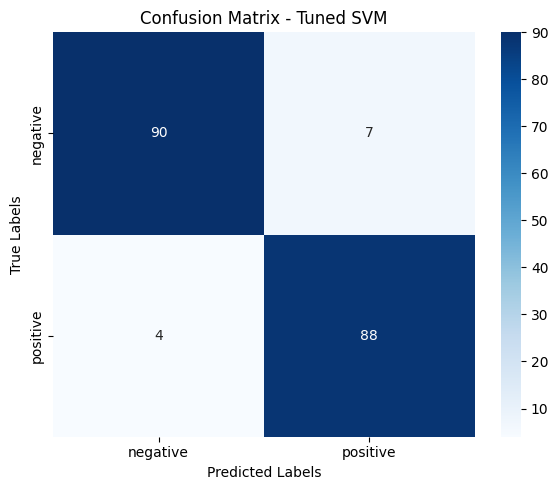

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump

# ==== Hyperparameter tuning dengan GridSearchCV ====
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # hanya untuk kernel non-linear
}

grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)  # Menggunakan X_train dan y_train yang sudah dipisahkan

# Menampilkan parameter terbaik
print(f"🎯 Best Parameters: {grid_search.best_params_}")
print(f"🎯 Best CV Score: {grid_search.best_score_:.4f}")

# Menggunakan model terbaik
svm_model = grid_search.best_estimator_

# Evaluasi pada data latih
svm_train_pred = svm_model.predict(X_train)
svm_train_acc = accuracy_score(y_train, svm_train_pred)


# Evaluasi pada data uji
svm_test_pred = svm_model.predict(X_test)
svm_test_acc = accuracy_score(y_test, svm_test_pred)

# Simpan model
dump(svm_model, 'model_svm_tuned.pkl')

# Output akurasi
print(f"✅ Akurasi Data Latih: {svm_train_acc:.4f}")
print(f"✅ Akurasi Data Uji: {svm_test_acc:.4f}")

# Classification report dan confusion matrix
print("Classification Report (Data Uji):")
print(classification_report(y_test, svm_test_pred))

cm_svm = confusion_matrix(y_test, svm_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative',  'positive'],
            yticklabels=['negative',  'positive'])
plt.title("Confusion Matrix - Tuned SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


📦 Model Naive Bayes Multinomial disimpan: model_nb_Gaussian_Fasttext.pkl
✅ Akurasi Naive Bayes: 0.6190476190476191
              precision    recall  f1-score   support

           0       0.59      0.89      0.70        97
           1       0.74      0.34      0.46        92

    accuracy                           0.62       189
   macro avg       0.66      0.61      0.58       189
weighted avg       0.66      0.62      0.59       189



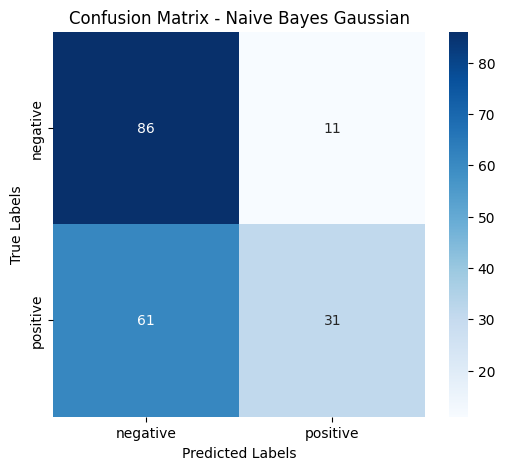

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# Inisialisasi model Naive Bayes Multinomial
nb_model = GaussianNB()

# Latih model Naive Bayes
nb_model.fit(X_train, y_train)  # Gunakan X_train dan y_train yang sudah di-split dengan FastText

# Prediksi dan evaluasi
nb_pred = nb_model.predict(X_test)  # Gunakan X_test dan y_test yang sudah di-split dengan FastText
nb_acc = accuracy_score(y_test, nb_pred)

# Simpan model Naive Bayes ke file
dump(nb_model, 'model_nb_Gaussian.pkl')
print(f"📦 Model Naive Bayes Multinomial disimpan: model_nb_Gaussian_Fasttext.pkl")

# Tampilkan akurasi, classification report, dan confusion matrix
print(f"✅ Akurasi Naive Bayes: {nb_acc}")
print(classification_report(y_test, nb_pred))

# Plot confusion matrix
cm_nb = confusion_matrix(y_test, nb_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix - Naive Bayes Gaussian")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
🎯 Best Parameters: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
🎯 Best CV Score: 0.9244
✅ Akurasi Data Latih: 0.9801
✅ Akurasi Data Uji: 0.9471
Classification Report (Data Uji):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        97
           1       0.94      0.96      0.95        92

    accuracy                           0.95       189
   macro avg       0.95      0.95      0.95       189
weighted avg       0.95      0.95      0.95       189



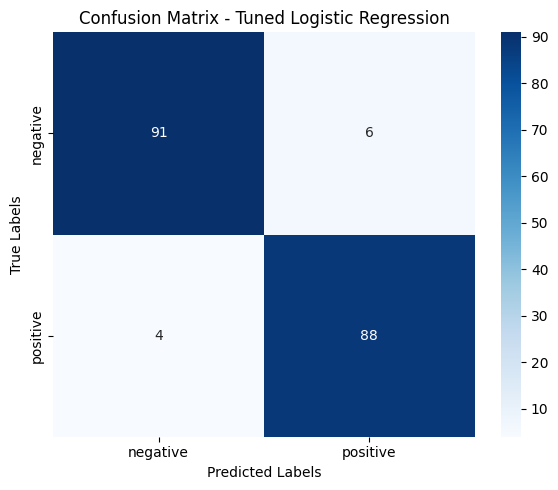

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump

# ==== Hyperparameter tuning dengan GridSearchCV ====
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print(f"🎯 Best Parameters: {grid_search.best_params_}")
print(f"🎯 Best CV Score: {grid_search.best_score_:.4f}")

# Menggunakan model terbaik
logreg_model = grid_search.best_estimator_

# Evaluasi pada data latih
logreg_train_pred = logreg_model.predict(X_train)
logreg_train_acc = accuracy_score(y_train, logreg_train_pred)


# Evaluasi pada data uji
logreg_test_pred = logreg_model.predict(X_test)
logreg_test_acc = accuracy_score(y_test, logreg_test_pred)

# Simpan model
dump(logreg_model, 'model_logreg_tuned.pkl')

# Output akurasi
print(f"✅ Akurasi Data Latih: {logreg_train_acc:.4f}")
print(f"✅ Akurasi Data Uji: {logreg_test_acc:.4f}")

# Classification report dan confusion matrix
print("Classification Report (Data Uji):")
print(classification_report(y_test, logreg_test_pred))

cm_logreg = confusion_matrix(y_test, logreg_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


In [ ]:

!pip install deslib==0.3.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.6/172.6 kB 5.3 MB/s eta 0:00:00


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters Logistic Regression: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

=== Voting Classifier ===
📦 Model Voting Classifier disimpan: model_voting_classifier.pkl
✅ Akurasi Voting Classifier: 0.9206349206349206

Classification Report Voting Classifier:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92        97
           1       0.94      0.89      0.92        92

    accuracy                           0.92       189
   macro avg       0.92      0.92      0.92       189
weighted avg       0.92      0.92      0.92       189



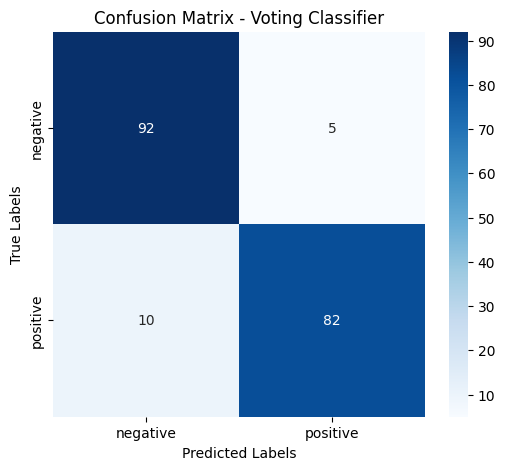


=== Stacking Classifier ===
📦 Model Stacking Classifier disimpan: model_stacking_classifier.pkl
✅ Akurasi Stacking Classifier: 0.9470899470899471

Classification Report Stacking Classifier:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95        97
           1       0.94      0.96      0.95        92

    accuracy                           0.95       189
   macro avg       0.95      0.95      0.95       189
weighted avg       0.95      0.95      0.95       189



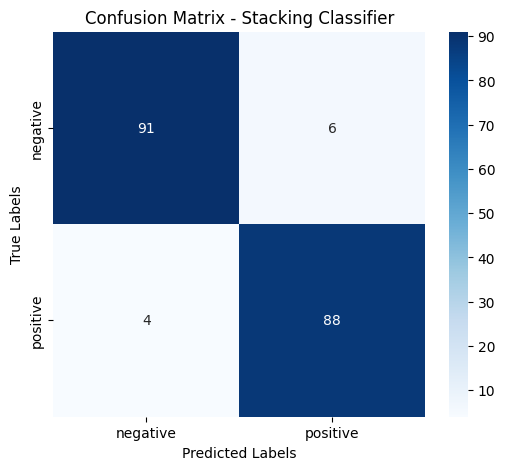


=== DES KNORA-E ===


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


📦 Model DES KNORA-E disimpan: model_des_knora-e.pkl
✅ Akurasi DES KNORA-E: 0.9470899470899471

Classification Report DES KNORA-E:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95        97
           1       0.94      0.96      0.95        92

    accuracy                           0.95       189
   macro avg       0.95      0.95      0.95       189
weighted avg       0.95      0.95      0.95       189



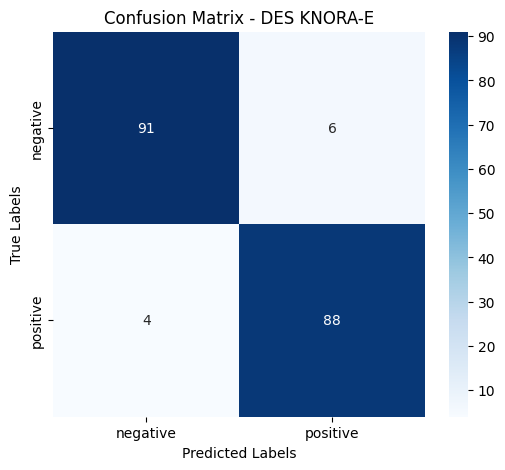

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump
from deslib.des.knora_e import KNORAE

# === GridSearch untuk tuning SVM ===
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # hanya untuk kernel non-linear
}

grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print("Best Parameters SVM:", grid_search_svm.best_params_)

# Inisialisasi model SVM dengan best params dari GridSearch
best_svm_params = grid_search_svm.best_params_
svm_model = SVC(
    probability=True,
    C=best_svm_params['C'],
    kernel=best_svm_params['kernel'],
    gamma=best_svm_params['gamma'],
    random_state=42
)

# === GridSearch untuk tuning Logistic Regression ===
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # LogisticRegression default pakai L2
    'solver': ['lbfgs'],  # solver yang umum untuk L2 dan multiclass
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search_lr = GridSearchCV(logreg, param_grid_lr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best Parameters Logistic Regression:", grid_search_lr.best_params_)

# Inisialisasi model Logistic Regression dengan best params dari GridSearch
best_lr_params = grid_search_lr.best_params_
lr_model = LogisticRegression(
    C=best_lr_params['C'],
    penalty=best_lr_params['penalty'],
    solver=best_lr_params['solver'],
    max_iter=best_lr_params['max_iter'],
    random_state=42
)

# Inisialisasi model Naive Bayes
nb_model = GaussianNB()

# === Latih model terlebih dahulu sebelum digunakan di DES ===
svm_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# === VotingClassifier ===
voting_clf = VotingClassifier(
    estimators=[('svm', svm_model), ('nb', nb_model), ('lr', lr_model)],
    voting='soft'
)

# === StackingClassifier ===
stacking_clf = StackingClassifier(
    estimators=[('svm', svm_model), ('nb', nb_model), ('lr', lr_model)],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5
)

# === Dynamic Ensemble Selection (DES) ===
# KNORA-E (K Nearest Optimal Classifier - Ensemble)
des_knorae = KNORAE(pool_classifiers=[svm_model, nb_model, lr_model], k=5)

# Daftar model untuk evaluasi
models = {
    'Voting Classifier': voting_clf,
    'Stacking Classifier': stacking_clf,
    'DES KNORA-E': des_knorae
}

# Latih dan evaluasi setiap model
for name, model in models.items():
    print(f"\n=== {name} ===")

    # Latih model
    model.fit(X_train, y_train)

    # Prediksi dan evaluasi pada test set
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # Simpan model ke file
    model_filename = f"model_{name.lower().replace(' ', '_')}.pkl"
    dump(model, model_filename)
    print(f"📦 Model {name} disimpan: {model_filename}")

    # Tampilkan akurasi dan classification report
    print(f"✅ Akurasi {name}: {acc}")
    print(f"\nClassification Report {name}:\n", classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['negative', 'positive'],
                yticklabels=['negative', 'positive'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
